# ML Analysis

In [1]:
# Import Packages
import pandas as pd 
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import json
import pyproj
import math
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import math
from decimal import Decimal, getcontext
import time
from geopandas import GeoDataFrame

/Users/apple/opt/anaconda3/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/var/folders/21/l9ygcw6d6w39m02vcn2t_j6r0000gn/T/ipykernel_63119/1301756820.py:4: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https:/

## Data Collection

Read Data

In [2]:
# Read Data

# Ethinic Group
ethnic_group_df = pd.read_excel('./data/demographic_dataset/Ethnic group.xlsx', sheet_name='2021',engine="openpyxl")

# Age Group
age_group_df = pd.read_excel('./data/demographic_dataset/Five year age bands.xlsx', sheet_name='2021',engine="openpyxl")

# General Health
general_hea_df = pd.read_excel('./data/demographic_dataset/General health.xlsx', sheet_name='2021',engine="openpyxl")

# Income
income_df = pd.read_excel('./data/demographic_dataset/modelled-household-income-estimates-lsoa2.xlsx', sheet_name='income',engine="openpyxl")

# LSOA data
file_path = "data/demographic_dataset/ESRI/LSOA_2011_London_gen_MHW.shp"

ldnwards = gpd.read_file(file_path)

OD Matrix

In [3]:
od_matrix = pd.read_excel('./data/od_matrix/od_matrix.xlsx',sheet_name='od_matrix',engine="openpyxl")
# 删除第一列
od_matrix = od_matrix.drop(columns=od_matrix.columns[0])

In [4]:
od_matrix.columns

Index(['From', 'station_origin', 'To', 'station_destination', 'early_flows',
       'ampeak_flows', 'midday_flows', 'pmpeak_flows', 'evening_flows',
       'late_flows', 'total_flows', 'orig_x', 'orig_y', 'dest_x', 'dest_y',
       'orig_coord_lat', 'orig_coord_lon', 'dest_coord_lat', 'dest_coord_lon',
       'fsip', 'fsip_ampeak', 'station_dis', 'ampeak_2work_flows',
       'ampeak_2edu_flows', 'ampeak_2other_flows', 'fsip_2work', 'fsip_2edu',
       'fsip_2other', 'fsip_ampeak_workandedu', 'fsip_ampeak_workandother',
       'fsip_ampeak_eduandother', 'fsip_2work(relative)',
       'fsip_2edu(relative)', 'fsip_2other(relative)',
       'fsip_ampeak_workandedu(relative)', 'fsip_ampeak_eduandother(relative)',
       'fsip_ampeak_workandother(relative)', 'relative_outflow(work)',
       'relative_inflow(work)', 'place_based_fsip(work)',
       'relative_outflow(edu)', 'relative_inflow(edu)',
       'place_based_fsip(edu)', 'relative_outflow(other)',
       'relative_inflow(other)', 'plac

Calculate the inflow and outflow

In [30]:
columns = ['station_name','relative_inflow(work)','relative_outflow(work)']
inout_df = pd.DataFrame(columns = columns)

stations_list = od_matrix['station_origin'].unique()
tmp_inflow, tmp_outflow = 0,0


# for i in range(0,len(stations_list)):
#     #print(od_matrix_cleaned[od_matrix_cleaned['station_origin'] == stations_list[i]]['fsip'])
#     tmp_outflow_set = set(od_matrix[od_matrix['station_origin'] == stations_list[i]]['fsip_ampeak'])
#     tmp_outflow = sum(tmp_outflow_set)

#     tmp_inflow_set = set(od_matrix[od_matrix['station_destination'] == stations_list[i]]['fsip_ampeak'])
#     tmp_inflow = sum(tmp_inflow_set)
    
    
#     new_row = {'station_name':stations_list[i], 'inflow':tmp_inflow, 'outflow':tmp_outflow}
#     inout_df = inout_df.append(new_row, ignore_index=True)

# for i in range(0,len(stations_list)):
#     tmp_outflow_set = set(od_matrix[od_matrix['station_origin'] == stations_list[i]]['fsip_ampeak'])

In [98]:
# 提取基于 "Column_Name" 列的唯一数据行
unique_rows = od_matrix.drop_duplicates(subset=['station_origin'])
unique_rows

,From,station_origin,To,station_destination,early_flows,ampeak_flows,midday_flows,pmpeak_flows,evening_flows,late_flows,...,place_based_fsip(other),relative_outflow(workandedu),relative_inflow(workandedu),place_based_fsip(workandedu),relative_outflow(eduandother),relative_inflow(eduandother),place_based_fsip(eduandother),relative_outflow(workandother),relative_inflow(workandother),place_based_fsip(workandother)
0,500,Acton Town,505,Alperton,0,50,0,99,0,0,...,2.257304,9.342471,3.411165,2.738792,6.326567,2.304111,2.745773,21.455004,9.416650,2.278412
122,526,Boston Manor,500,Acton Town,76,127,0,0,0,0,...,0.698830,5.550615,6.595454,0.841582,3.589129,4.482654,0.800671,12.766767,17.398832,0.733771
200,545,Chiswick Park,500,Acton Town,0,5,32,2,16,0,...,0.983811,7.103938,6.595454,1.077096,4.371712,4.482654,0.975251,18.699689,17.398832,1.074767
303,560,Ealing Broadway,500,Acton Town,85,85,44,168,14,2,...,2.137221,16.161574,6.595454,2.450411,10.662907,4.482654,2.378704,38.145831,17.398832,2.192436
492,561,Ealing Common,500,Acton Town,33,29,22,21,11,0,...,1.032598,7.654170,6.595454,1.160522,4.893138,4.482654,1.091572,18.984893,17.398832,1.091159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29523,667,Osterley,500,Acton Town,0,32,12,7,11,0,...,0.900875,5.877654,6.595454,0.891167,3.576201,4.482654,0.797786,17.355001,17.398832,0.997481
29637,713,Stamford Brook,500,Acton Town,0,0,3,34,0,0,...,0.000000,8.039638,6.595454,0.000000,5.383303,4.482654,0.000000,19.144826,17.398832,1.100351
29764,621,Kew Gardens,500,Acton Town,0,0,21,0,7,0,...,0.000000,6.218738,6.595454,0.000000,3.960660,4.482654,0.000000,15.956512,17.398832,0.917102
29880,686,Richmond,500,Acton Town,3,1,1,3,31,57,...,1.092962,8.142087,6.595454,1.234500,4.874424,4.482654,1.087397,21.130566,17.398832,1.214482


In [93]:
columns = ['station_name','inflow','outflow','coord_x','coord_y']
inout_df = pd.DataFrame(columns = columns)

for i in range(0,len(stations_list)):
    #print(od_matrix_cleaned[od_matrix_cleaned['station_origin'] == stations_list[i]]['fsip'])
    tmp_outflow_set = set(od_matrix[od_matrix['station_origin'] == stations_list[i]]['relative_outflow(work)'])
    tmp_outflow = sum(tmp_outflow_set)

    tmp_inflow_set = set(od_matrix[od_matrix['station_origin'] == stations_list[i]]['relative_inflow(work)'])
    print(od_matrix[od_matrix['station_origin'] == stations_list[i]][['station_origin','relative_inflow(work)']])
    tmp_inflow = sum(tmp_inflow_set)
    
    coord_x = od_matrix[od_matrix['station_origin'] == stations_list[i]]['orig_x'].unique()[0]
    coord_y = od_matrix[od_matrix['station_origin'] == stations_list[i]]['orig_y'].unique()[0]
    
    
    new_row = {'station_name':stations_list[i], 'inflow':tmp_inflow, 'outflow':tmp_outflow, 'coord_x':coord_x, 'coord_y':coord_y}
    inout_df = inout_df.append(new_row, ignore_index=True)


    station_origin  relative_inflow(work)
0       Acton Town               6.733013
1       Acton Town              32.207660
2       Acton Town              15.430389
3       Acton Town               2.855925
4       Acton Town              37.392486
..             ...                    ...
117     Acton Town               8.210991
118     Acton Town              12.396499
119     Acton Town               2.349627
120     Acton Town              14.861683
121     Acton Town               4.448363

[122 rows x 2 columns]
    station_origin  relative_inflow(work)
122   Boston Manor              12.497756
123   Boston Manor              32.207660
124   Boston Manor              15.430389
125   Boston Manor              37.392486
126   Boston Manor              14.136508
..             ...                    ...
195   Boston Manor              41.662599
196   Boston Manor              23.783936
197   Boston Manor              12.396499
198   Boston Manor              14.861683
199   Bost

     station_origin  relative_inflow(work)
1556  Turnham Green              12.497756
1557  Turnham Green              28.469044
1558  Turnham Green               6.733013
1559  Turnham Green              32.207660
1560  Turnham Green              15.430389
...             ...                    ...
1689  Turnham Green              23.783936
1690  Turnham Green               8.210991
1691  Turnham Green              12.396499
1692  Turnham Green               2.349627
1693  Turnham Green               3.736692

[138 rows x 2 columns]
     station_origin  relative_inflow(work)
1694     West Acton              28.469044
1695     West Acton              37.392486
1696     West Acton               8.750440
1697     West Acton              17.691175
1698     West Acton              38.975502
1699     West Acton               6.671762
1700     West Acton              23.021372
1701     West Acton              39.690203
1702     West Acton              23.736979
1703     West Acton           

[168 rows x 2 columns]
     station_origin  relative_inflow(work)
3908  Stepney Green              28.469044
3909  Stepney Green              32.207660
3910  Stepney Green              15.430389
3911  Stepney Green              37.392486
3912  Stepney Green               8.750440
...             ...                    ...
4041  Stepney Green               6.398273
4042  Stepney Green              14.861683
4043  Stepney Green               4.448363
4044  Stepney Green               3.736692
4045  Stepney Green               4.741002

[138 rows x 2 columns]
     station_origin  relative_inflow(work)
4046    Whitechapel              12.497756
4047    Whitechapel              28.469044
4048    Whitechapel              32.207660
4049    Whitechapel              15.430389
4050    Whitechapel               5.455838
...             ...                    ...
4199    Whitechapel              12.396499
4200    Whitechapel               2.349627
4201    Whitechapel               4.448363
4202   

     station_origin  relative_inflow(work)
7118     Old Street              12.497756
7119     Old Street              23.411160
7120     Old Street              28.469044
7121     Old Street               6.733013
7122     Old Street              32.207660
...             ...                    ...
7322     Old Street               2.349627
7323     Old Street              14.861683
7324     Old Street               4.448363
7325     Old Street               3.736692
7326     Old Street               4.741002

[209 rows x 2 columns]
     station_origin  relative_inflow(work)
7327    Arnos Grove              23.411160
7328    Arnos Grove              32.207660
7329    Arnos Grove               2.855925
7330    Arnos Grove              37.392486
7331    Arnos Grove              33.603596
...             ...                    ...
7412    Arnos Grove              13.703672
7413    Arnos Grove              41.662599
7414    Arnos Grove              25.652307
7415    Arnos Grove           

[118 rows x 2 columns]
     station_origin  relative_inflow(work)
9720    Marble Arch              28.469044
9721    Marble Arch              32.207660
9722    Marble Arch              15.430389
9723    Marble Arch               5.455838
9724    Marble Arch               2.855925
...             ...                    ...
9876    Marble Arch              12.396499
9877    Marble Arch               2.349627
9878    Marble Arch              14.861683
9879    Marble Arch               3.736692
9880    Marble Arch               4.741002

[161 rows x 2 columns]
      station_origin  relative_inflow(work)
9881      Marylebone              23.411160
9882      Marylebone              28.469044
9883      Marylebone               6.733013
9884      Marylebone              32.207660
9885      Marylebone              15.430389
...              ...                    ...
10033     Marylebone              23.783936
10034     Marylebone               6.398273
10035     Marylebone              14.8616

[80 rows x 2 columns]
      station_origin  relative_inflow(work)
13299          Upney              28.469044
13300          Upney              37.392486
13301          Upney              33.603596
13302          Upney              14.136508
13303          Upney               4.457487
...              ...                    ...
13369          Upney              13.703672
13370          Upney               8.590995
13371          Upney              41.662599
13372          Upney              25.652307
13373          Upney              23.783936

[75 rows x 2 columns]
      station_origin  relative_inflow(work)
13374    Barkingside              28.469044
13375    Barkingside              37.392486
13376    Barkingside              14.136508
13377    Barkingside              10.235291
13378    Barkingside              17.691175
13379    Barkingside              38.975502
13380    Barkingside              17.987032
13381    Barkingside              39.690203
13382    Barkingside           

[147 rows x 2 columns]
         station_origin  relative_inflow(work)
14949  Ravenscourt Park              12.497756
14950  Ravenscourt Park              28.469044
14951  Ravenscourt Park               6.733013
14952  Ravenscourt Park              32.207660
14953  Ravenscourt Park               5.455838
...                 ...                    ...
15068  Ravenscourt Park               9.239559
15069  Ravenscourt Park              41.662599
15070  Ravenscourt Park              23.783936
15071  Ravenscourt Park               8.210991
15072  Ravenscourt Park              12.396499

[124 rows x 2 columns]
               station_origin  relative_inflow(work)
15073  Shepherd's Bush Market              28.469044
15074  Shepherd's Bush Market              32.207660
15075  Shepherd's Bush Market               2.855925
15076  Shepherd's Bush Market              37.392486
15077  Shepherd's Bush Market              33.603596
...                       ...                    ...
15136  Shepherd's 

      station_origin  relative_inflow(work)
16863  Goodge Street              28.469044
16864  Goodge Street               6.733013
16865  Goodge Street              32.207660
16866  Goodge Street              15.430389
16867  Goodge Street               8.750440
...              ...                    ...
16977  Goodge Street              41.662599
16978  Goodge Street               6.398273
16979  Goodge Street              12.396499
16980  Goodge Street               2.349627
16981  Goodge Street               4.741002

[119 rows x 2 columns]
      station_origin  relative_inflow(work)
16982      Hampstead              23.411160
16983      Hampstead              32.207660
16984      Hampstead              15.430389
16985      Hampstead               5.455838
16986      Hampstead              37.392486
...              ...                    ...
17074      Hampstead               9.506851
17075      Hampstead              23.783936
17076      Hampstead              12.396499
17077   

[101 rows x 2 columns]
      station_origin  relative_inflow(work)
20247       Highgate              23.411160
20248       Highgate              28.469044
20249       Highgate              32.207660
20250       Highgate              15.430389
20251       Highgate              37.392486
...              ...                    ...
20353       Highgate              41.662599
20354       Highgate              25.652307
20355       Highgate              23.783936
20356       Highgate              14.861683
20357       Highgate               4.741002

[111 rows x 2 columns]
      station_origin  relative_inflow(work)
20358    Manor House              12.497756
20359    Manor House              23.411160
20360    Manor House               6.733013
20361    Manor House              32.207660
20362    Manor House              15.430389
...              ...                    ...
20468    Manor House              17.611990
20469    Manor House              41.662599
20470    Manor House         

[107 rows x 2 columns]
       station_origin  relative_inflow(work)
21979  Mill Hill East              23.411160
21980  Mill Hill East              28.469044
21981  Mill Hill East              32.207660
21982  Mill Hill East              15.430389
21983  Mill Hill East              33.603596
...               ...                    ...
22046  Mill Hill East              47.567059
22047  Mill Hill East              29.968773
22048  Mill Hill East              43.415651
22049  Mill Hill East              25.652307
22050  Mill Hill East               4.741002

[72 rows x 2 columns]
               station_origin  relative_inflow(work)
22051  Totteridge & Whetstone              23.411160
22052  Totteridge & Whetstone              28.469044
22053  Totteridge & Whetstone              32.207660
22054  Totteridge & Whetstone              15.430389
22055  Totteridge & Whetstone              37.392486
...                       ...                    ...
22132  Totteridge & Whetstone              

[74 rows x 2 columns]
            station_origin  relative_inflow(work)
23986  Harrow & Wealdstone              23.411160
23987  Harrow & Wealdstone              28.469044
23988  Harrow & Wealdstone              32.207660
23989  Harrow & Wealdstone              15.430389
23990  Harrow & Wealdstone              37.392486
...                    ...                    ...
24051  Harrow & Wealdstone               4.910909
24052  Harrow & Wealdstone              13.703672
24053  Harrow & Wealdstone               8.590995
24054  Harrow & Wealdstone              41.662599
24055  Harrow & Wealdstone               6.398273

[70 rows x 2 columns]
           station_origin  relative_inflow(work)
24056  Harrow-on-the-Hill              12.497756
24057  Harrow-on-the-Hill              23.411160
24058  Harrow-on-the-Hill              28.469044
24059  Harrow-on-the-Hill               6.733013
24060  Harrow-on-the-Hill              32.207660
...                   ...                    ...
24179  Harro

      station_origin  relative_inflow(work)
25458   Earl's Court              12.497756
25459   Earl's Court              28.469044
25460   Earl's Court               6.733013
25461   Earl's Court              32.207660
25462   Earl's Court              15.430389
...              ...                    ...
25639   Earl's Court              12.396499
25640   Earl's Court               2.349627
25641   Earl's Court              14.861683
25642   Earl's Court               3.736692
25643   Earl's Court               4.741002

[186 rows x 2 columns]
        station_origin  relative_inflow(work)
25644  Gloucester Road              12.497756
25645  Gloucester Road              28.469044
25646  Gloucester Road              32.207660
25647  Gloucester Road              15.430389
25648  Gloucester Road               5.455838
...                ...                    ...
25807  Gloucester Road              23.783936
25808  Gloucester Road               8.210991
25809  Gloucester Road            

[101 rows x 2 columns]
      station_origin  relative_inflow(work)
28170       Ickenham              12.497756
28171       Ickenham              23.411160
28172       Ickenham              37.392486
28173       Ickenham              33.603596
28174       Ickenham              25.724935
28175       Ickenham              38.975502
28176       Ickenham               3.446731
28177       Ickenham              21.371197
28178       Ickenham              45.798127
28179       Ickenham              28.352852
28180       Ickenham               9.053098
28181       Ickenham              23.597904
28182       Ickenham               6.181927
28183       Ickenham               7.433662
28184       Ickenham              27.054240
28185       Ickenham               4.873337
28186       Ickenham              29.569540
28187       Ickenham              33.863280
28188       Ickenham              21.160839
28189       Ickenham              34.677133
28190       Ickenham              16.201677
28191    

[106 rows x 2 columns]
      station_origin  relative_inflow(work)
29332  Hounslow East              12.497756
29333  Hounslow East              23.411160
29334  Hounslow East              28.469044
29335  Hounslow East               6.733013
29336  Hounslow East              32.207660
...              ...                    ...
29445  Hounslow East              23.783936
29446  Hounslow East               6.398273
29447  Hounslow East              12.396499
29448  Hounslow East              14.861683
29449  Hounslow East               4.741002

[118 rows x 2 columns]
      station_origin  relative_inflow(work)
29450  Hounslow West              12.497756
29451  Hounslow West              37.392486
29452  Hounslow West              25.724935
29453  Hounslow West              30.872365
29454  Hounslow West              17.987032
...              ...                    ...
29518  Hounslow West              43.415651
29519  Hounslow West              17.611990
29520  Hounslow West         

In [88]:
inout_df

,station_name,inflow,outflow,coord_x,coord_y
0,Acton Town,2402.549459,15.802151,519484,179592
1,Boston Manor,1891.324742,9.859333,516391,178753
2,Chiswick Park,2228.483360,14.751910,520324,178714
3,Ealing Broadway,3196.121853,28.804877,517951,180953
4,Ealing Common,2301.850852,14.604946,518892,180386
...,...,...,...,...,...
238,Osterley,2279.578185,14.080194,514515,177083
239,Stamford Brook,2591.295630,14.227686,521870,178791
240,Kew Gardens,2427.662951,12.286778,519197,176740
241,Richmond,2944.002435,16.856788,518110,175185


In [39]:
# Inflow top30 stations
inout_df.sort_values(by=["inflow"],ascending= False, inplace = True)
inflow_head30 = inout_df.head(30)

# Outflow top30 stations
inout_df.sort_values(by=["outflow"],ascending= False, inplace = True)
outflow_head30 = inout_df.head(30)

## Data Preparation

### Demographic Dataframe Proprocessing

#### Ethnic Group

In [5]:
# 将所有列的首行大小写置换并替换空格
ethnic_group_df.columns = [col.lower().replace(' ', '_') for col in ethnic_group_df.columns]

# Total white 
ethnic_group_df['white_total'] = ethnic_group_df['white_british'] + ethnic_group_df['white_irish'] + ethnic_group_df['white_gypsy/irish_traveller'] + \
                                                       ethnic_group_df['white_roma'] + ethnic_group_df['white_other']

# Total Asian
ethnic_group_df['asian_total'] = ethnic_group_df['asian_bangladeshi'] + ethnic_group_df['asian_chinese'] + ethnic_group_df['asian_indian'] + \
                                 ethnic_group_df['asian_other'] + ethnic_group_df['asian_pakistani']

# Total Black
ethnic_group_df['black_total'] = ethnic_group_df['black_african'] + ethnic_group_df['black_caribbean'] + ethnic_group_df['black_other']

In [6]:
selected_columns = ['lsoa_code', 'local_authority_name', 'all_usual_residents', 'white_total', 'asian_total', 'black_total']

ethnic_df = ethnic_group_df[selected_columns]

#### Age Group

In [7]:
#age_group_df.columns
age_group_df.columns = [col.lower().replace(' ', '_') for col in age_group_df.columns]

# Total teeneger
age_group_df['teenager_age'] = age_group_df['aged_10_to_14'] + age_group_df['aged_15_to_19']

# Total Young Adult
age_group_df['young_age'] = age_group_df['aged_20_to_24'] + age_group_df['aged_25_to_29'] +  age_group_df['aged_30_to_34'] + age_group_df['aged_35_to_39']

# Total Middle Age
age_group_df['middle_age'] = age_group_df['aged_40_to_44'] + age_group_df['aged_45_to_49'] + age_group_df['aged_50_to_54'] + age_group_df['aged_55_to_59'] + age_group_df['aged_60_to_64']

# Total Old
age_group_df['old_age'] = age_group_df['aged_65_to_69'] + age_group_df['aged_70_to_74'] + age_group_df['aged_75_to_79'] + age_group_df['aged_80_to_84'] + age_group_df['aged_85_and_over']

In [8]:
selected_columns = ['lsoa_code', 'local_authority_name', 'all_usual_residents', 'teenager_age',
                    'young_age', 'middle_age', 'old_age']
age_df = age_group_df[selected_columns]

#### Income

In [11]:
# income_df columns
income_df.columns =[col.lower().replace(' ', '_') for col in income_df.columns]

# 
income_df['house_pri'] = (income_df['mean_2010/11'] + income_df['mean_2011/12'] + income_df['mean_2012/13'])/ 3

income_df.rename(columns={'code': 'lsoa_code'}, inplace=True)

In [12]:
selected_columns = ['lsoa_code', 'name', 'house_pri']
income_df = income_df[selected_columns]

In [19]:
od_matrix.columns

Index(['From', 'station_origin', 'To', 'station_destination', 'early_flows',
       'ampeak_flows', 'midday_flows', 'pmpeak_flows', 'evening_flows',
       'late_flows', 'total_flows', 'orig_x', 'orig_y', 'dest_x', 'dest_y',
       'orig_coord_lat', 'orig_coord_lon', 'dest_coord_lat', 'dest_coord_lon',
       'fsip', 'fsip_ampeak', 'station_dis', 'ampeak_2work_flows',
       'ampeak_2edu_flows', 'ampeak_2other_flows', 'fsip_2work', 'fsip_2edu',
       'fsip_2other', 'fsip_ampeak_workandedu', 'fsip_ampeak_workandother',
       'fsip_ampeak_eduandother', 'fsip_2work(relative)',
       'fsip_2edu(relative)', 'fsip_2other(relative)',
       'fsip_ampeak_workandedu(relative)', 'fsip_ampeak_eduandother(relative)',
       'fsip_ampeak_workandother(relative)', 'relative_outflow(work)',
       'relative_inflow(work)', 'place_based_fsip(work)',
       'relative_outflow(edu)', 'relative_inflow(edu)',
       'place_based_fsip(edu)', 'relative_outflow(other)',
       'relative_inflow(other)', 'plac

#### LSOA Data

In [13]:
lsoa_ldnwards = ldnwards[['LSOA11CD','LSOA11NM','geometry']]
# 将所有列的首行大小写置换并替换空格
lsoa_ldnwards.columns = [col.lower().replace(' ', '_') for col in lsoa_ldnwards.columns]

# 计算polygon的中心点
lsoa_ldnwards['center'] = lsoa_ldnwards['geometry'].centroid

# 获取中心点的经纬度坐标
lsoa_ldnwards['center_y'] = lsoa_ldnwards['center'].y
lsoa_ldnwards['center_x'] = lsoa_ldnwards['center'].x

/Users/apple/opt/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


### Combine Demographic Data and OD Matrix Data

此部分包含四个步骤：

1. 从od_matrix中提取部分columns作为新的DF，包括: origin_station, destination_station, fsip, orig_x, orig_y, dest_x, dest_y


2. 根据inflow的排名，删除掉一些带有特定站点的数据，这些站点包括：'Moorgate',
 'Liverpool Street',
 'London Bridge',
 'Oxford Circus',
 'Green Park',
 'Westminster',
 'Euston',
 'Canary Wharf',
 'Farringdon',
 'Holborn',
 'Barbican',
 "King's Cross St. Pancras",
 'Piccadilly Circus',
 "St. James's Park",
 'Tottenham Court Road',
 'Old Street',
 'Warren Street',
 'Embankment'


3. 计算新的DF中每条flow中距离起点站和终点站最近的LSOA

4. 聚合人口统计数据和flow数据

#### Station Exclusion

In [99]:
# 读取JSON文件中的JSON数组
with open('./data/tfl_stations.json', 'r') as file:
    stations = json.load(file)

# 读取JSON文件中的JSON数组
with open('./data/tfl_lines.json', 'r') as file:
    lines = json.load(file)

In [100]:
# index1: 多少行数据
# index2: 行数据中的第几个
def add_data(index1, index2,df):
    tmp_data={}
    if(stations['features'][index1]['properties']['lines'][index2]['name'] == 'National Rail' or stations['features'][index1]['properties']['lines'][index2]['name'] == 'Tramlink' ):
        tmp_data = {'stations':stations['features'][index1]['properties']['name'] ,
                    'coordinates':stations['features'][index1]['geometry']['coordinates'] ,
                    'lines':stations['features'][index1]['properties']['lines'][index2]['name']}
        df = df.append(tmp_data,ignore_index=True)
    return df

In [101]:
#定义excluded_sta

columns = ['stations','coordinates','lines']
excluded_sta = pd.DataFrame(columns=columns)

# 筛选出tfl_stations中包含 'Tramlink' 和 'National Rail'的地铁站 （其中有重复数据）
for i in range(0,len(stations['features'])):
    if(len(stations['features'][i]['properties']['lines']) == 1):
        excluded_sta = add_data(i,0,excluded_sta)                  
    elif(len(stations['features'][i]['properties']['lines']) == 2):
        excluded_sta = add_data(i,0,excluded_sta)
        excluded_sta = add_data(i,1,excluded_sta) 
    elif(len(stations['features'][i]['properties']['lines']) == 3):
        excluded_sta = add_data(i,0,excluded_sta)
        excluded_sta = add_data(i,1,excluded_sta) 
        excluded_sta = add_data(i,2,excluded_sta)
    elif(len(stations['features'][i]['properties']['lines']) == 4):
        excluded_sta = add_data(i,0,excluded_sta)
        excluded_sta = add_data(i,1,excluded_sta) 
        excluded_sta = add_data(i,2,excluded_sta)
        excluded_sta = add_data(i,3,excluded_sta) 
    elif(len(stations['features'][i]['properties']['lines']) == 5):
        excluded_sta = add_data(i,0,excluded_sta)
        excluded_sta = add_data(i,1,excluded_sta) 
        excluded_sta = add_data(i,2,excluded_sta)
        excluded_sta = add_data(i,3,excluded_sta) 
        excluded_sta = add_data(i,4,excluded_sta)
    elif(len(stations['features'][i]['properties']['lines']) == 6):
        excluded_sta = add_data(i,0,excluded_sta)
        excluded_sta = add_data(i,1,excluded_sta) 
        excluded_sta = add_data(i,2,excluded_sta)
        excluded_sta = add_data(i,3,excluded_sta) 
        excluded_sta = add_data(i,4,excluded_sta)
        excluded_sta = add_data(i,5,excluded_sta)
    elif(len(stations['features'][i]['properties']['lines']) == 7):
        excluded_sta = add_data(i,0,excluded_sta)
        excluded_sta = add_data(i,1,excluded_sta) 
        excluded_sta = add_data(i,2,excluded_sta)
        excluded_sta = add_data(i,3,excluded_sta) 
        excluded_sta = add_data(i,4,excluded_sta)
        excluded_sta = add_data(i,6,excluded_sta)

In [102]:
# 根据'stations'列进行筛选，找出独特的数据行
excluded_sta = excluded_sta.drop_duplicates(subset=['stations'])
excluded_sta.reset_index(drop=True, inplace=True)

In [103]:
# Transform Coordinates from WGB84 to National Britsh Grid

# Define the CRS84 (latitude, longitude) and BNG (British National Grid) coordinate reference systems
crs84 = pyproj.CRS("EPSG:4326")  # EPSG code for CRS84 (WGS 84)
bng = pyproj.CRS("EPSG:27700")   # EPSG code for British National Grid

# Create a coordinate transformer
transformer = pyproj.Transformer.from_crs(crs84, bng, always_xy=True)

coord_x = []
coord_y = []

# Transform the coordinates and update the JSON
for i in range (0,len(excluded_sta)):
    lon, lat = excluded_sta['coordinates'][i][0], excluded_sta['coordinates'][i][1]
    x, y = transformer.transform(lon, lat)
    coord_x.append(x)
    coord_y.append(y)
    
    
excluded_sta["coordinates_x"] = coord_x
excluded_sta["coordinates_y"] = coord_y

/Users/apple/opt/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


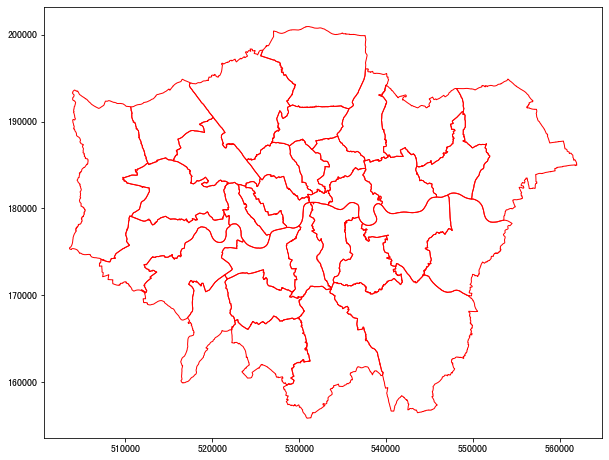

In [104]:
# Read London Data
file = "./data/LAD_Dec_2015_Generalised_Clipped_Boundaries_GB.geojson"
EW = gpd.read_file(file)

London = EW[EW.lad15cd.str.contains("E09")]

#transform london to BNG
London.to_crs("EPSG:27700", inplace = True)
#We can check that this has occured by plotting the results
London.plot(figsize = (10,15), facecolor = "None", edgecolor = "r")
plt.show()

In [105]:
# 定义地图范围的边界框，假设为[minx, miny, maxx, maxy]
minx, miny, maxx, maxy = London.total_bounds
excluded_sta = excluded_sta[(excluded_sta['coordinates_x'] >= minx) & (excluded_sta['coordinates_x'] <= maxx)]
excluded_sta = excluded_sta[(excluded_sta['coordinates_y'] >= miny) & (excluded_sta['coordinates_y'] <= maxy)]
excluded_sta

,stations,coordinates,lines,coordinates_x,coordinates_y
0,Blackfriars,"[-0.103139988780659, 51.51177409676423]",National Rail,531727.424144,180910.571417
1,Elephant & Castle,"[-0.100544988787323, 51.49538329675418]",National Rail,531954.789432,179092.536181
2,Finsbury Park,"[-0.1063375688362, 51.56463857774401]",National Rail,531353.378259,186783.547920
3,Greenford,"[-0.344816288858051, 51.54218769678803]",National Rail,514881.148818,183885.817658
4,Harrow & Wealdstone,"[-0.335398788831483, 51.59232129681883]",National Rail,515407.300643,189475.854557
...,...,...,...,...,...
145,West Croydon,"[-0.1023, 51.3784239]",National Rail,532169.875931,166083.274734
146,West Drayton,"[-0.471897288922074, 51.5098128967703]",National Rail,506143.942598,180093.761381
147,West Ealing,"[-0.320472588861861, 51.51351309676991]",National Rail,516642.430420,180735.491713
148,Wandsworth Road,"[-0.138179469161229, 51.46968303029571]",National Rail,529415.128556,176167.470693


/Users/apple/opt/anaconda3/lib/python3.9/site-packages/geopandas/base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
/Users/apple/opt/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


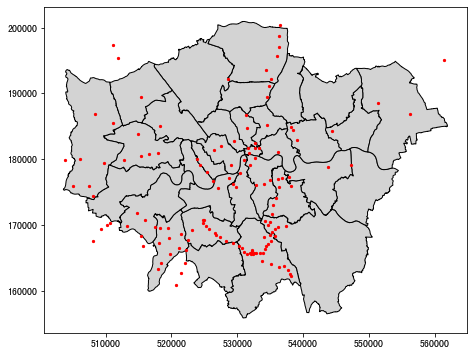

In [106]:
# 假设DataFrame中的坐标列分别为'x'和'y'
geometry = gpd.points_from_xy(excluded_sta['coordinates_x'], excluded_sta['coordinates_y'])
gdf = gpd.GeoDataFrame(excluded_sta, geometry=geometry)
# 设置gdf的坐标系统为当前的WGS84 (EPSG:4326)
gdf.set_crs(epsg=27700, inplace=True)

# 转换gdf的坐标系统为National British Grid (EPSG:27700)
#invalid_geometries = gdf[gdf.geometry.is_valid == False]
#gdf = gdf.to_crs(epsg=27700)
gdf

# 删除不在地图范围内的数据，并重置索引
gdf_within_bounds = gdf[gdf['geometry'].within(London)].reset_index(drop=True)
gdf_within_bounds

# 假设DataFrame中的坐标列分别为'x'和'y'
#geometry = gpd.points_from_xy(excluded_sta["coordinates_x"], excluded_sta["coordinates_y"])
#gdf_within_bounds.plot(ax=ax, marker='o', color='red', markersize=5)
ax = London.plot(color='lightgrey', edgecolor='black', figsize=(10, 6))
gdf.plot(ax=ax, marker='o', color='red', markersize=5)
#London.plot(figsize = (10,15), facecolor = "None", edgecolor = "r")
plt.show()

In [107]:
#  step1
df = od_matrix[['station_origin','orig_x','orig_y']]
df.drop_duplicates(subset=['station_origin'], keep='first', inplace=True)
df.reset_index(drop=True, inplace=True)
excluded_sta.reset_index(drop=True, inplace=True)

/var/folders/21/l9ygcw6d6w39m02vcn2t_j6r0000gn/T/ipykernel_63119/1230323999.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset=['station_origin'], keep='first', inplace=True)


In [108]:
from numpy import sqrt 

# 筛选出需要删除的地铁站
selected_sta = pd.DataFrame(columns = df.columns)
tmp = 0
for i in range(0,len(df)):
    for j in range(0, len(excluded_sta)):
        tmp_dis = sqrt((df['orig_x'][i] - excluded_sta['coordinates_x'][j])**2 + (df['orig_y'][i] - excluded_sta['coordinates_y'][j])**2)
        if(tmp_dis < 1000):
            new_row = {'station_origin':df['station_origin'][i],'orig_x':df['orig_x'][i] ,'orig_y':df['orig_y'][i]}
            selected_sta = selected_sta.append(new_row, ignore_index=True)

In [109]:
# 删除od_matrix中的对应数据

values_to_exclude = selected_sta['station_origin'].tolist()
mask1 = od_matrix['station_origin'].isin(values_to_exclude)
mask2 = od_matrix['station_destination'].isin(values_to_exclude)

combined_mask = mask1 | mask2

od_matrix_new = od_matrix[~combined_mask]
od_matrix_new.reset_index(drop=True, inplace=True)

#### Select the inflow and outflow data of each station

In [348]:
len(od_matrix_new['relative_inflow(work)'].unique())
inout_df = pd.DataFrame()

In [349]:
# 提取Inflow Data
unique_rows = od_matrix_new.drop_duplicates(subset=['station_origin'])
unique_rows = unique_rows[['station_origin','relative_outflow(work)','orig_x','orig_y']]
unique_rows.rename(columns={'station_origin': 'station'}, inplace=True)

In [350]:
## 提取Outflow data
unique_rows1 = od_matrix_new.drop_duplicates(subset=['station_destination'])
unique_rows1 = unique_rows1[['station_destination','relative_inflow(work)']]
unique_rows1.rename(columns={'station_destination': 'station'}, inplace=True)

In [351]:
inout_df = pd.merge(unique_rows,unique_rows1, on='station')
inout_df.rename(columns={'orig_x': 'coord_x'}, inplace=True)
inout_df.rename(columns={'orig_y': 'coord_y'}, inplace=True)

In [297]:
column_to_stay = ['station_origin', 'station_destination', 'orig_x', 'orig_y', 'dest_x', 'dest_y','fsip_ampeak_workandedu(relative)']
unique_rows2 = od_matrix_new.drop_duplicates(subset=['fsip_ampeak_workandedu(relative)'])
unique_rows2.reset_index(drop=True, inplace=True)
unique_rows2 = unique_rows2[column_to_stay]

#### 为人口统计数据加入LSOA的坐标数据

In [154]:
# 假设df是你的DataFrame，new_column是你要添加的新列
ethnic_df['coord_x'] = None  # 使用None表示空值
ethnic_df['coord_y'] = None  # 使用None表示空值

age_df['coord_x'] = None  # 使用None表示空值
age_df['coord_y'] = None  # 使用None表示空值

income_df['coord_x'] = None  # 使用None表示空值
income_df['coord_y'] = None  # 使用None表示空值

health_df['coord_x'] = None  # 使用None表示空值
health_df['coord_y'] = None  # 使用None表示空值


lsoa_ldnwards.rename(columns={'lsoa11cd': 'lsoa_code'}, inplace=True)

/Users/apple/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4300: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [155]:
### Ethnic
merged_df1 = ethnic_df.merge(lsoa_ldnwards, on='lsoa_code', suffixes=('_df1', '_df2'), how='inner')

# 将lsoa_ldnwards中的'center_x'，'center_y'赋值给ethnic_df中的 'coord_x','coord_y'
ethnic_df.loc[merged_df1.index, 'coord_x'] = merged_df1['center_x']
ethnic_df.loc[merged_df1.index, 'coord_y'] = merged_df1['center_y']


### Age
merged_df2 = age_df.merge(lsoa_ldnwards, on='lsoa_code', suffixes=('_df1', '_df2'), how='inner')

# 将lsoa_ldnwards中的'center_x'，'center_y'赋值给ethnic_df中的 'coord_x','coord_y'
age_df.loc[merged_df2.index, 'coord_x'] = merged_df2['center_x']
age_df.loc[merged_df2.index, 'coord_y'] = merged_df2['center_y']


### Income
merged_df3 = income_df.merge(lsoa_ldnwards, on='lsoa_code', suffixes=('_df1', '_df2'), how='inner')

# 将lsoa_ldnwards中的'center_x'，'center_y'赋值给ethnic_df中的 'coord_x','coord_y'
income_df.loc[merged_df3.index, 'coord_x'] = merged_df3['center_x']
income_df.loc[merged_df3.index, 'coord_y'] = merged_df3['center_y']

### Health
merged_df4 = health_df.merge(lsoa_ldnwards, on='lsoa_code', suffixes=('_df1', '_df2'), how='inner')

# 将lsoa_ldnwards中的'center_x'，'center_y'赋值给ethnic_df中的 'coord_x','coord_y'
health_df.loc[merged_df4.index, 'coord_x'] = merged_df4['center_x']
health_df.loc[merged_df4.index, 'coord_y'] = merged_df4['center_y']

In [157]:
# 删除包含空值的列
ethnic_df = ethnic_df.dropna()
age_df = age_df.dropna()
income_df = income_df.dropna()

#### 聚合人口统计 和 流数据

#####  Orig

In [356]:
from scipy.spatial.distance import cdist

##### Ethnic
# 确保DataFrame中的坐标列是数值类型
inout_df['coord_x'] = inout_df['coord_x'].astype(float)
inout_df['coord_y'] = inout_df['coord_y'].astype(float)
ethnic_df['coord_x'] = ethnic_df['coord_x'].astype(float)
ethnic_df['coord_y'] = ethnic_df['coord_y'].astype(float)

# 使用cdist函数计算df1和df2中所有点之间的距离
ethnic_distances = cdist(inout_df[['coord_x', 'coord_y']], ethnic_df[['coord_x', 'coord_y']])

# 找到距离最近的坐标在df2中的索引
nearest_indexes = ethnic_distances.argmin(axis=1)

# 根据索引找到对应的坐标
nearest_coordinates = ethnic_df.iloc[nearest_indexes][['white_total', 'asian_total','black_total']]

# 将找到的最近坐标添加到df1中
inout_df[['white_total(orig)', 'asian_total(orig)', 'black_total(orig)']] = nearest_coordinates.values
##### Ethnic


##### Age
# 确保DataFrame中的坐标列是数值类型
inout_df['coord_x'] = inout_df['coord_x'].astype(float)
inout_df['coord_y'] = inout_df['coord_y'].astype(float)
age_df['coord_x'] = age_df['coord_x'].astype(float)
age_df['coord_y'] = age_df['coord_y'].astype(float)

# 使用cdist函数计算df1和df2中所有点之间的距离
age_distances = cdist(inout_df[['coord_x', 'coord_y']], age_df[['coord_x', 'coord_y']])

# 找到距离最近的坐标在df2中的索引
nearest_indexes = age_distances.argmin(axis=1)

# 根据索引找到对应的坐标
nearest_coordinates = age_df.iloc[nearest_indexes][['teenager_age', 'young_age','middle_age','old_age']]

# 将找到的最近坐标添加到df1中
inout_df[['teenager_age(orig)', 'young_age(orig)', 'middle_age(orig)', 'old_age(orig)']] = nearest_coordinates.values
##### Age


##### Income
# 确保DataFrame中的坐标列是数值类型
inout_df['coord_x'] = inout_df['coord_x'].astype(float)
inout_df['coord_y'] = inout_df['coord_y'].astype(float)
income_df['coord_x'] = income_df['coord_x'].astype(float)
income_df['coord_y'] = income_df['coord_y'].astype(float)

# 使用cdist函数计算df1和df2中所有点之间的距离
income_distances = cdist(inout_df[['coord_x', 'coord_y']], income_df[['coord_x', 'coord_y']])

# 找到距离最近的坐标在df2中的索引
nearest_indexes = income_distances.argmin(axis=1)

# 根据索引找到对应的坐标
nearest_coordinates = income_df.iloc[nearest_indexes][['house_pri']]

# 将找到的最近坐标添加到df1中
inout_df[['house_pri(orig)']] = nearest_coordinates.values
##### Income

In [343]:
unique_rows['relative_inflow(work)'].max()

38.97550199420828

#####  Dest

In [299]:
from scipy.spatial.distance import cdist

##### Ethnic
# 确保DataFrame中的坐标列是数值类型
unique_rows2['dest_x'] = unique_rows2['dest_x'].astype(float)
unique_rows2['dest_y'] = unique_rows2['dest_y'].astype(float)
ethnic_df['coord_x'] = ethnic_df['coord_x'].astype(float)
ethnic_df['coord_y'] = ethnic_df['coord_y'].astype(float)

# 使用cdist函数计算df1和df2中所有点之间的距离
ethnic_distances = cdist(unique_rows2[['dest_x', 'dest_y']], ethnic_df[['coord_x', 'coord_y']])

# 找到距离最近的坐标在df2中的索引
nearest_indexes = ethnic_distances.argmin(axis=1)

# 根据索引找到对应的坐标
nearest_coordinates = ethnic_df.iloc[nearest_indexes][['white_total', 'asian_total','black_total']]

# 将找到的最近坐标添加到df1中
unique_rows2[['white_total(dest)', 'asian_total(dest)', 'black_total(dest)']] = nearest_coordinates.values
##### Ethnic


##### Age
# 确保DataFrame中的坐标列是数值类型
unique_rows2['dest_x'] = unique_rows2['dest_x'].astype(float)
unique_rows2['dest_y'] = unique_rows2['dest_y'].astype(float)
age_df['coord_x'] = age_df['coord_x'].astype(float)
age_df['coord_y'] = age_df['coord_y'].astype(float)

# 使用cdist函数计算df1和df2中所有点之间的距离
age_distances = cdist(unique_rows2[['dest_x', 'dest_y']], age_df[['coord_x', 'coord_y']])

# 找到距离最近的坐标在df2中的索引
nearest_indexes = age_distances.argmin(axis=1)

# 根据索引找到对应的坐标
nearest_coordinates = age_df.iloc[nearest_indexes][['teenager_age', 'young_age','middle_age','old_age']]

# 将找到的最近坐标添加到df1中
unique_rows2[['teenager_age(dest)', 'young_age(dest)', 'middle_age(dest)', 'old_age(dest)']] = nearest_coordinates.values
##### Age


##### Income
# 确保DataFrame中的坐标列是数值类型
unique_rows2['dest_x'] = unique_rows2['dest_x'].astype(float)
unique_rows2['dest_y'] = unique_rows2['dest_y'].astype(float)
income_df['coord_x'] = income_df['coord_x'].astype(float)
income_df['coord_y'] = income_df['coord_y'].astype(float)

# 使用cdist函数计算df1和df2中所有点之间的距离
income_distances = cdist(unique_rows2[['dest_x', 'dest_y']], income_df[['coord_x', 'coord_y']])

# 找到距离最近的坐标在df2中的索引
nearest_indexes = income_distances.argmin(axis=1)

# 根据索引找到对应的坐标
nearest_coordinates = income_df.iloc[nearest_indexes][['house_pri']]

# 将找到的最近坐标添加到df1中
unique_rows2[['house_pri(dest)']] = nearest_coordinates.values
##### Income

## Feature Engineering

In [361]:
inout_df['relative_outflow(work)'].max()

31.06761181096314

In [337]:
# 假设你的DataFrame为df，columns_to_normalize为需要进行归一化的列名
columns_to_normalize = ['relative_outflow(work)', 'relative_inflow(work)',
       'white_total(orig)', 'asian_total(orig)', 'black_total(orig)',
       'teenager_age(orig)', 'young_age(orig)', 'middle_age(orig)',
       'old_age(orig)', 'house_pri(orig)']

# 初始化MinMaxScaler对象
scaler = MinMaxScaler()

# 对选定的列进行归一化
inout_df[columns_to_normalize] = scaler.fit_transform(inout_df[columns_to_normalize])

In [607]:
inout_df1 = inout_df[new_order]

In [606]:
new_order = ['relative_outflow(work)',
       'relative_inflow(work)', 'white_total(orig)', 'asian_total(orig)',
       'black_total(orig)', 'teenager_age(orig)', 'young_age(orig)',
       'middle_age(orig)', 'old_age(orig)', 'house_pri(orig)']

<AxesSubplot:>

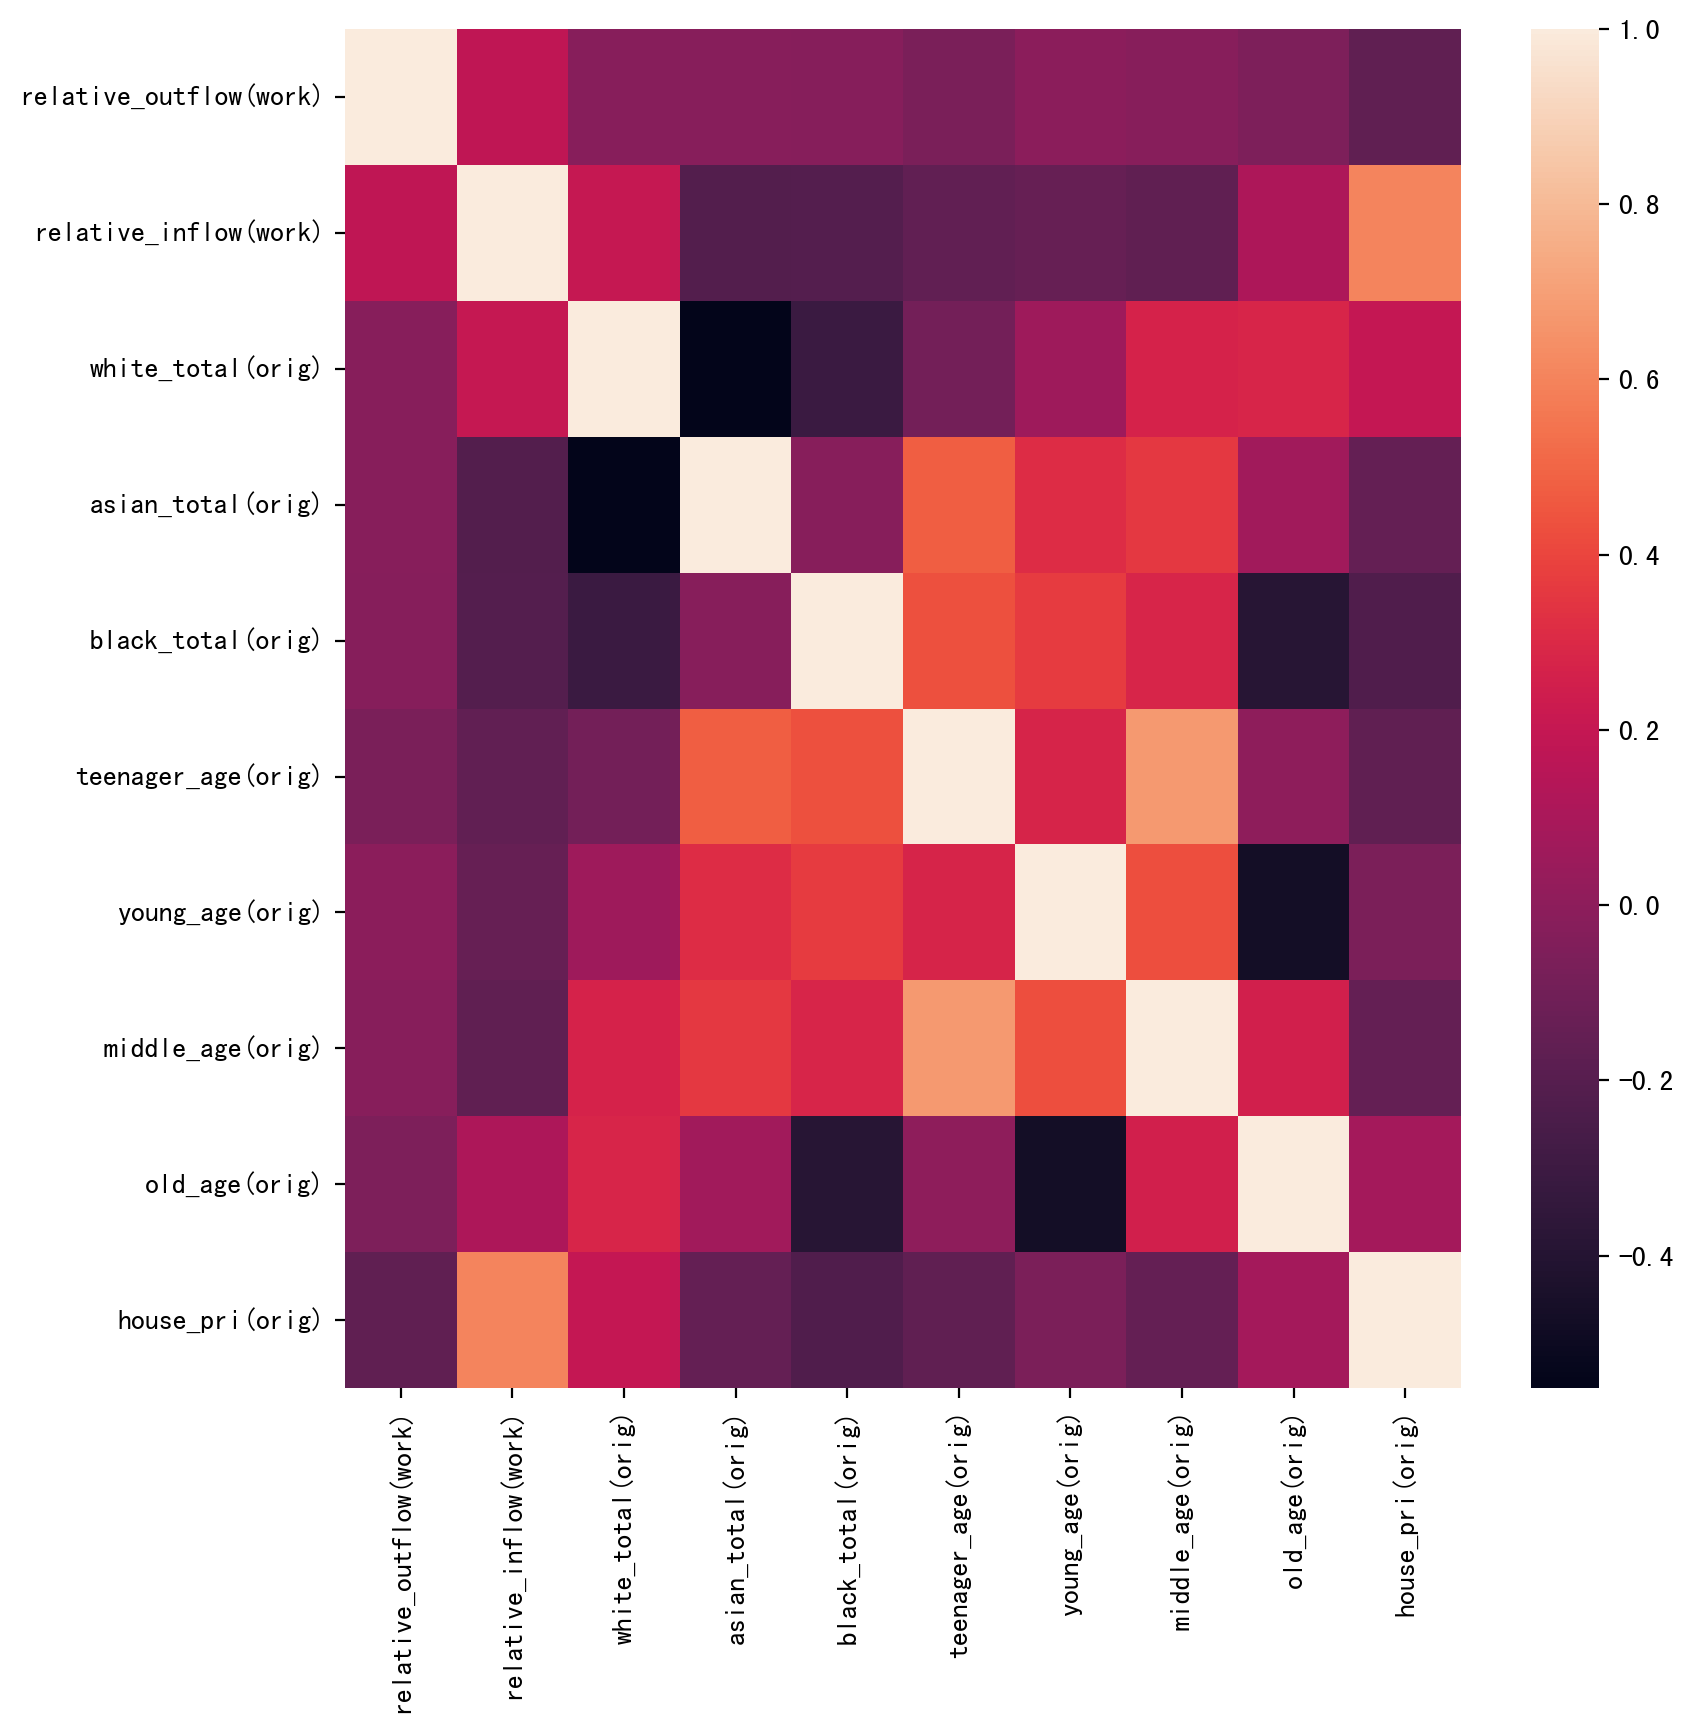

In [608]:
inout_df_corr1 = inout_df1.corr(method='pearson')
plt.figure(figsize=(9, 9),dpi=200)
sns.heatmap(data=inout_df_corr1,)

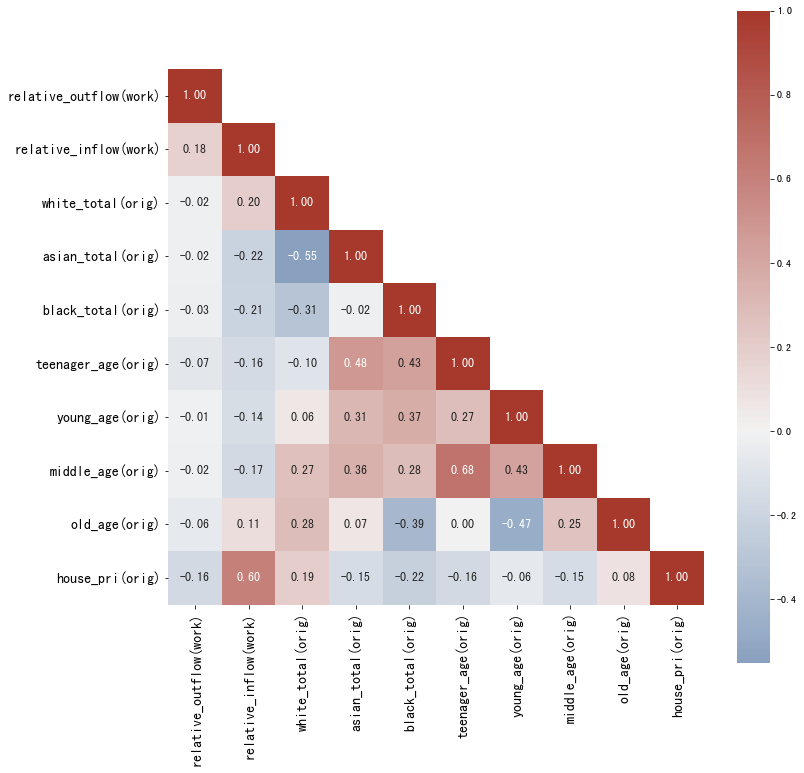

In [609]:
ut = np.triu(inout_df_corr1, k=1) #下半图
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                            n=9, center="light", as_cmap=True)

annot_kws = {"size": 12}
plt.figure(figsize=(12, 12))
sns.heatmap(inout_df_corr1, mask=ut, center=0, annot=True,
            fmt='.2f', square=True, cmap=cmap, annot_kws=annot_kws)
# 设置坐标轴标签和刻度的字体大小
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('./figure/heatmap.pdf')
plt.show();

### Normalized

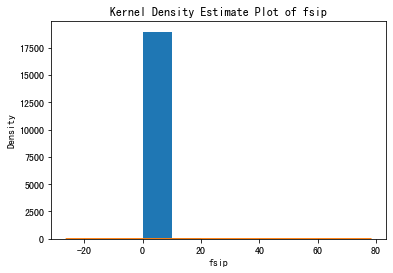

In [123]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设你的DataFrame为df，column_name为要观察的列名
column_name = 'fsip'

# 绘制直方图
plt.hist(od_df[column_name], bins=[0,10,20,30])  # 可以根据需要调整bins的数量
plt.title('Histogram of {}'.format(column_name))
plt.xlabel(column_name)
plt.ylabel('Frequency')

# 绘制核密度估计图
# df[column_name].plot.kde()  # 也可以使用这种方式绘制核密度估计图
od_df[column_name].plot.density()
plt.title('Kernel Density Estimate Plot of {}'.format(column_name))
plt.xlabel(column_name)
plt.ylabel('Density')

# 显示图形
plt.show()

In [175]:
from sklearn.preprocessing import MinMaxScaler

def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range
 
def standardization(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return (data - mu) / sigma

In [126]:
od_df.columns

Index(['From', 'station_origin', 'To', 'station_destination', 'early_flows',
       'ampeak_flows', 'midday_flows', 'pmpeak_flows', 'evening_flows',
       'late_flows', 'total_flows', 'orig_x', 'orig_y', 'dest_x', 'dest_y',
       'orig_coord_lat', 'orig_coord_lon', 'dest_coord_lat', 'dest_coord_lon',
       'fsip', 'fsip_ampeak', 'station_dis', 'ampeak_2work_flows',
       'ampeak_2edu_flows', 'ampeak_2other_flows', 'fsip_2work', 'fsip_2edu',
       'fsip_2other', 'fsip_ampeak_workandedu', 'fsip_ampeak_workandother',
       'fsip_ampeak_eduandother', 'fsip_2work(relative)',
       'fsip_2edu(relative)', 'fsip_2other(relative)',
       'fsip_ampeak_workandedu(relative)', 'fsip_ampeak_eduandother(relative)',
       'fsip_ampeak_workandother(relative)', 'relative_outflow(work)',
       'relative_inflow(work)', 'place_based_fsip(work)',
       'relative_outflow(edu)', 'relative_inflow(edu)',
       'place_based_fsip(edu)', 'relative_outflow(other)',
       'relative_inflow(other)', 'plac

In [127]:
# 假设你的DataFrame为df，columns_to_normalize为需要进行归一化的列名
columns_to_normalize = ['white_total(orig)',
       'asian_total(orig)', 'black_total(orig)', 'teenager_age(orig)',
       'young_age(orig)', 'middle_age(orig)', 'old_age(orig)',
       'house_pri(orig)', 'health_good(orig)', 'health_fair(orig)',
       'health_bad(orig)', 'white_total(dest)', 'asian_total(dest)',
       'black_total(dest)', 'teenager_age(dest)', 'young_age(dest)',
       'middle_age(dest)', 'old_age(dest)', 'house_pri(dest)',
       'health_good(dest)', 'health_fair(dest)', 'health_bad(dest)']

# 初始化MinMaxScaler对象
scaler = MinMaxScaler()

# 对选定的列进行归一化
od_df[columns_to_normalize] = scaler.fit_transform(od_df[columns_to_normalize])

/var/folders/21/l9ygcw6d6w39m02vcn2t_j6r0000gn/T/ipykernel_42851/2091706216.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  od_df[columns_to_normalize] = scaler.fit_transform(od_df[columns_to_normalize])
/Users/apple/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


### VIF

In [ ]:
# calculating VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [368]:
column_to_vif = ['relative_outflow(work)', 'relative_inflow(work)', 'white_total(orig)', 'asian_total(orig)',
       'black_total(orig)', 'teenager_age(orig)', 'young_age(orig)',
       'middle_age(orig)', 'old_age(orig)', 'house_pri(orig)']
variables = inout_df[column_to_vif]
variables

,relative_outflow(work),relative_inflow(work),white_total(orig),asian_total(orig),black_total(orig),teenager_age(orig),young_age(orig),middle_age(orig),old_age(orig),house_pri(orig)
0,15.802151,12.497756,891,277,232,289,492,605,180,43023.333333
1,9.859333,6.543465,1184,327,59,196,444,601,247,49176.666667
2,14.751910,9.053098,907,676,529,296,932,790,216,60010.000000
3,14.604946,7.433662,1080,262,136,274,370,615,244,52886.666667
4,12.596819,10.479147,786,323,351,242,551,545,180,50493.333333
...,...,...,...,...,...,...,...,...,...,...
153,14.080194,6.480033,1389,1004,284,332,1108,828,239,53183.333333
154,14.227686,6.696063,628,760,113,217,477,558,185,65416.666667
155,12.286778,8.267823,745,424,192,77,958,283,19,82413.333333
156,16.856788,18.608216,871,1053,164,305,683,669,282,66543.333333


In [369]:
# using VIF on the bike_rental dataset
#df_new = drop_column_using_vif_(df)
df_predictors_selected_VIF = drop_column_using_vif_(variables)
# Note that there is a 'while' loop in the drop_column_using_vif_. In each iteration, one variable is dropped.
print("The columns remaining after VIF selection are:")
print(df_predictors_selected_VIF.columns)

Dropping: asian_total(orig)
The columns remaining after VIF selection are:
Index(['relative_outflow(work)', 'relative_inflow(work)', 'white_total(orig)',
       'black_total(orig)', 'teenager_age(orig)', 'young_age(orig)',
       'middle_age(orig)', 'old_age(orig)', 'house_pri(orig)'],
      dtype='object')


In [371]:
inout_df_p = inout_df.drop('asian_total(orig)', axis=1)

## Model Traning

### 对Y值取log

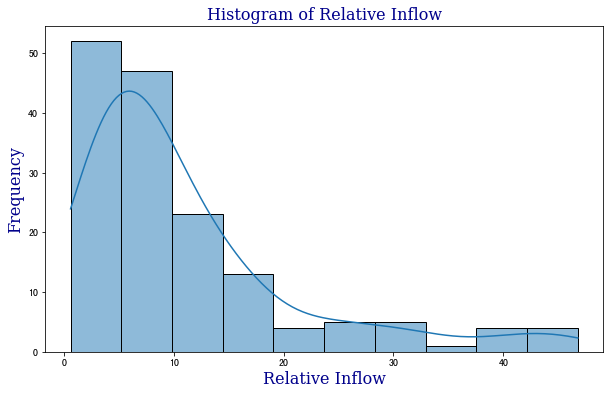

In [598]:
import seaborn as sns
import matplotlib.pyplot as plt

# 绘制直方图和分布趋势走向线
plt.figure(figsize=(10, 6))
sns.histplot(data=inout_df, x='relative_inflow(work)', bins=10, kde=True)

# 设置标题和标签的字体大小
font = {'family': 'serif', 'color':  'darkblue', 'weight': 'normal', 'size': 16}
plt.title('Histogram of Relative Inflow', fontdict=font)
plt.xlabel('Relative Inflow', fontdict=font)
plt.ylabel('Frequency', fontdict=font)

plt.savefig('./figure/relative_inflow_distribution.pdf')
# 显示图形
plt.show()


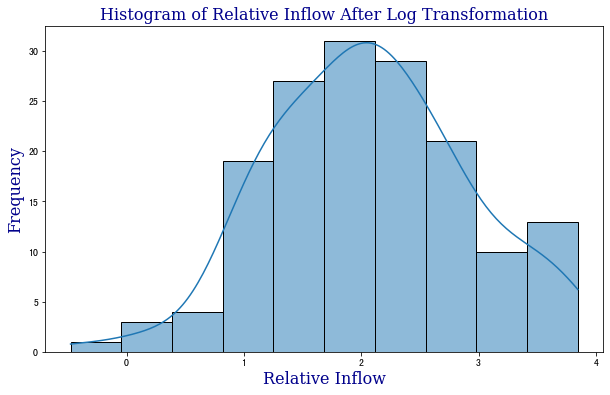

In [672]:
import seaborn as sns
import matplotlib.pyplot as plt

# 绘制直方图和分布趋势走向线
plt.figure(figsize=(10, 6))
sns.histplot(data=inout_df, x='log_inflow', bins=10, kde=True)

# 设置标题和标签的字体大小
font = {'family': 'serif', 'color':  'darkblue', 'weight': 'normal', 'size': 16}
plt.title('Histogram of Relative Inflow After Log Transformation', fontdict=font)
plt.xlabel('Relative Inflow', fontdict=font)
plt.ylabel('Frequency', fontdict=font)
plt.savefig('./figure/relative_inflow_distribution_after_log.pdf')
# 显示图形
plt.show()


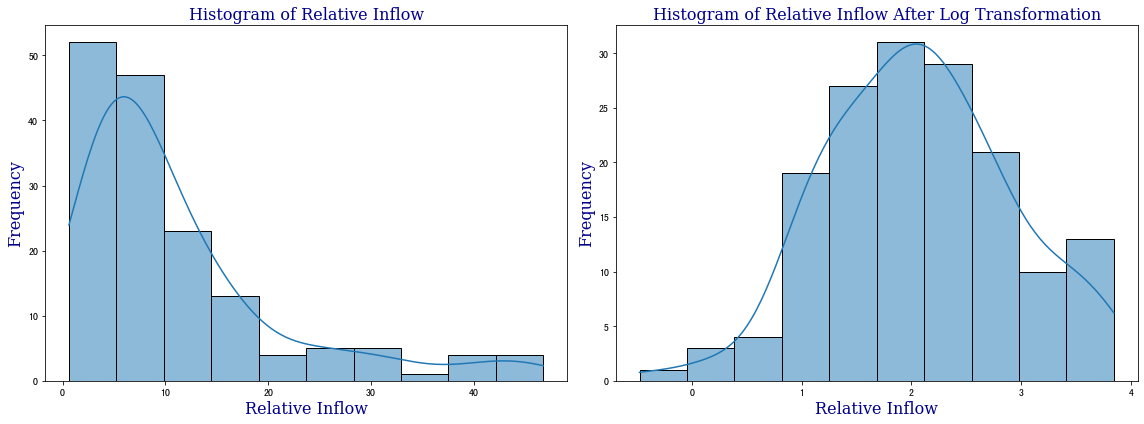

In [673]:
import seaborn as sns
import matplotlib.pyplot as plt

# 创建一个包含多个子图的图表
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# 绘制第一个子图：直方图和分布趋势走向线
sns.histplot(data=inout_df, x='relative_inflow(work)', bins=10, kde=True, ax=axes[0])
axes[0].set_title('Histogram of Relative Inflow', fontdict=font)
axes[0].set_xlabel('Relative Inflow', fontdict=font)
axes[0].set_ylabel('Frequency', fontdict=font)

# 绘制第二个子图：直方图和分布趋势走向线
sns.histplot(data=inout_df, x='log_inflow', bins=10, kde=True, ax=axes[1])
axes[1].set_title('Histogram of Relative Inflow After Log Transformation', fontdict=font)
axes[1].set_xlabel('Relative Inflow', fontdict=font)
axes[1].set_ylabel('Frequency', fontdict=font)

# 调整子图之间的间距和布局
plt.tight_layout()

# 保存图形
plt.savefig('./figure/relative_inflow_combined.pdf')

# 显示图形
plt.show()


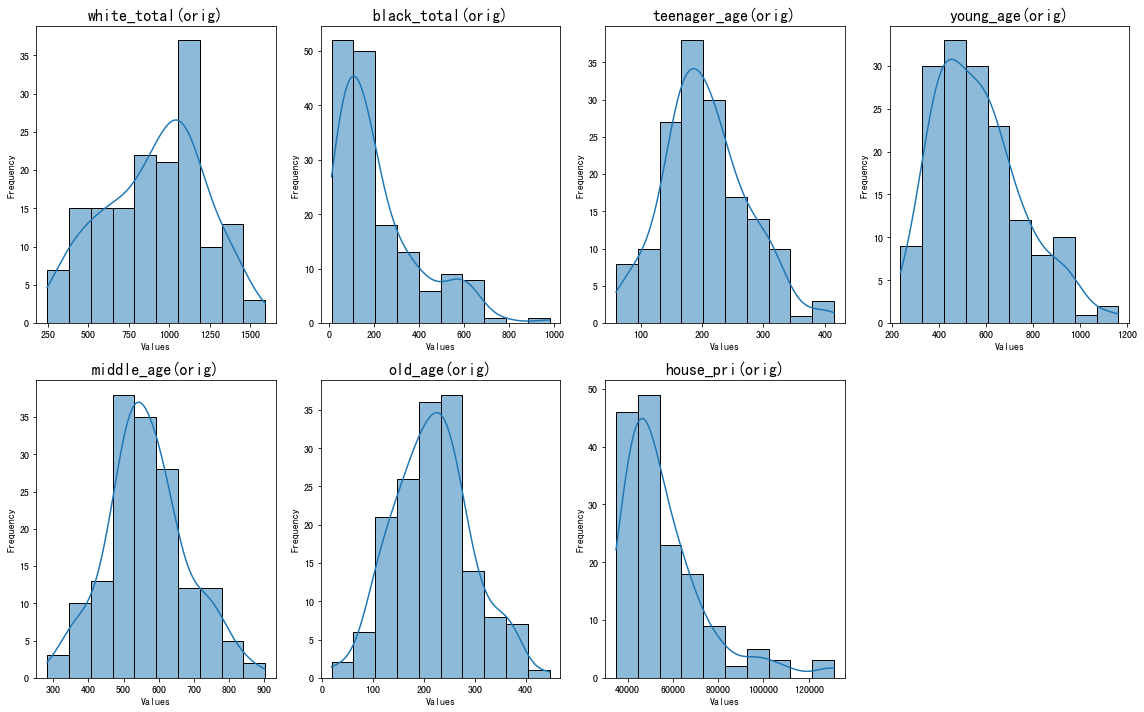

In [600]:
import seaborn as sns
import matplotlib.pyplot as plt

# 创建一个包含多个子图的图表
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 10))

# 数据集中的8列数据
columns = ['white_total(orig)',
       'black_total(orig)', 'teenager_age(orig)', 'young_age(orig)',
       'middle_age(orig)', 'old_age(orig)', 'house_pri(orig)']

# 在每个子图中绘制直方图和分布趋势走向线
for i, ax in enumerate(axes.flat):
    if i < len(columns):
        sns.histplot(data=inout_df, x=columns[i], bins=10, kde=True, ax=ax, line_kws={'color': 'green'})
        ax.set_title(columns[i], fontsize=16)
        ax.set_xlabel('Values')
        ax.set_ylabel('Frequency')

# 删除多余的子图
for i in range(len(columns), len(axes.flatten())):
    fig.delaxes(axes.flatten()[i])

# 调整子图之间的间距和布局
plt.tight_layout()

plt.savefig('./figure/relative_inflow_distribution_independent.pdf')
# 显示图形
plt.show()


### Moran's I

In [380]:
pip install contexily

ERROR: Could not find a version that satisfies the requirement contexily (from versions: none)
ERROR: No matching distribution found for contexily

[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [504]:
import pysal
import esda
import pandas as pd
import libpysal as lps
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
#import contexily as ctx
from pylab import figure, scatter, show

In [505]:
from shapely.geometry import Point

# 转换geometry列
inout_df['geometry'] = inout_df.apply(lambda row: Point(row['coord_x'], row['coord_y']), axis=1)

column_to_go = ['coord_x','coord_y']
inout_df.drop(column_to_go,axis=1)

# # 创建GeoDataFrame，并设置其坐标系为British National Grid
gdf1 = gpd.GeoDataFrame(inout_df, crs='EPSG:27700', geometry='geometry')

wq = lps.weights.Queen.from_dataframe(gdf1)

# 标准化矩阵
wq.transform = 'r'

In [506]:
centroids = gdf1.geometry.centroid

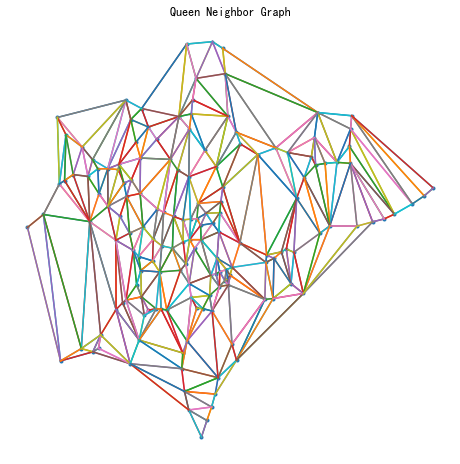

In [507]:
fig = figure(figsize=(8,8))

plt.plot(centroids.x, centroids.y,'.')
for k,neighs in wq.neighbors.items():
    #print(k,neighs)
    origin = centroids[k]
    for neigh in neighs:
        segment = centroids[[k,neigh]]
        plt.plot(segment.x, segment.y, '-')
plt.title('Queen Neighbor Graph')
plt.axis('off')
plt.show()

In [414]:
wq

In [425]:
esda.moran.Moran?

Moran's I 值为： 0.646227331479253
随机分布假设下Z检验值为： 13.80194724827467
随机分布假设下Z检验的P值为： 0.0
正态分布假设下Z检验值为： 13.671611060948365
正态分布假设下Z检验的P值为： 0.0


#### 绘制Moran's I散点图 -> 证明空间依赖性

Moran散点图分为四个象限，分别表示四种局部空间相关关系：

- 第一象限（HH）：高值区被高值包围


- 第二象限（LH）：低值区被高值包围


- 第三象限（LL）：低值区被低值包围


- 第四象限（HL）：高值区被低值包围

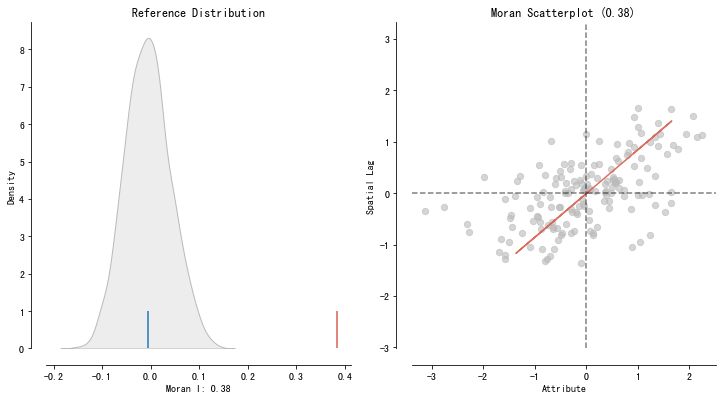

In [613]:
from splot.esda import plot_moran

plot_moran(mi, zstandard=True, figsize=(12,6))

plt.savefig('./figure/moranI.pdf')
plt.show()


### 经典OLS

In [560]:
import statsmodels.api as sm

x = inout_df[['white_total(orig)', 'asian_total(orig)',
       'black_total(orig)', 'teenager_age(orig)', 'young_age(orig)',
       'middle_age(orig)', 'old_age(orig)', 'house_pri(orig)']]
y = inout_df['log_inflow']
x=sm.add_constant(x) #添加常数项
est=sm.OLS(y,x)
model=est.fit()#建立最小二乘回归模型
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             log_inflow   R-squared:                       0.294
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     7.773
Date:                Tue, 15 Aug 2023   Prob (F-statistic):           1.09e-08
Time:                        23:12:22   Log-Likelihood:                -168.84
No. Observations:                 158   AIC:                             355.7
Df Residuals:                     149   BIC:                             383.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.5892      0

In [614]:
2.053e-05

2.053e-05

### 空间自相关的描述

#### Spatial-Autocorrelation Test of Dependent

In [561]:
y=gdf1["relative_inflow(work)"]
mi = esda.moran.Moran(y, wq)

print("Moran's I 值为：",mi.I)
print("随机分布假设下Z检验值为：",mi.z_rand)
print("随机分布假设下Z检验的P值为：",mi.p_rand)
print("正态分布假设下Z检验值为：",mi.z_norm)
print("正态分布假设下Z检验的P值为：",mi.p_norm)

Moran's I 值为： 0.646227331479253
随机分布假设下Z检验值为： 13.80194724827467
随机分布假设下Z检验的P值为： 0.0
正态分布假设下Z检验值为： 13.671611060948365
正态分布假设下Z检验的P值为： 0.0


#### Spatial-Autocorrelation Test of Residuals

In [562]:
residuals = model.resid

mi = esda.moran.Moran(residuals, wq)

print("Moran's I 值为：",mi.I)
print("随机分布假设下Z检验值为：",mi.z_rand)
print("随机分布假设下Z检验的P值为：",mi.p_rand)
print("正态分布假设下Z检验值为：",mi.z_norm)
print("正态分布假设下Z检验的P值为：",mi.p_norm)

Moran's I 值为： 0.38341839345773326
随机分布假设下Z检验值为： 8.168446195928425
随机分布假设下Z检验的P值为： 2.220446049250313e-16
正态分布假设下Z检验值为： 8.165881008424675
正态分布假设下Z检验的P值为： 2.220446049250313e-16


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :  log_inflow                Number of Observations:         158
Mean dependent var  :      2.0701                Number of Variables   :           8
S.D. dependent var  :      0.8413                Degrees of Freedom    :         150
R-squared           :      0.2864
Adjusted R-squared  :      0.2531
Sum squared residual:      79.302                F-statistic           :      8.6018
Sigma-square        :       0.529                Prob(F-statistic)     :   7.532e-09
S.E. of regression  :       0.727                Log likelihood        :    -169.735
Sigma-square ML     :       0.502                Akaike info criterion :     355.470
S.E of regression ML:      0.7085                Schwarz criterion     :     379.971

-----------------------------------------------------------------------------

### Breusch-Pagan检验 和 Koenker-Bassett检验

Breusch-Pagan检验（Breusch-Pagan test）和Koenker-Bassett检验（Koenker-Bassett test）都是用于检验回归模型中异方差性（heteroscedasticity）的统计检验方法。

Breusch-Pagan检验：
Breusch-Pagan检验是一种用于检验线性回归模型中异方差性的检验方法。它的原假设是模型的误差方差是恒定的（同方差性），备择假设是误差方差存在异方差性。该检验基于残差的平方与自变量之间的关系，如果这种关系存在，可能表明异方差性的存在。如果p-value（显著性水平）小于预先设定的阈值（通常为0.05），则可以拒绝原假设，认为模型存在异方差性。

Koenker-Bassett检验：
Koenker-Bassett检验是一种用于检验线性回归模型中异方差性的鲁棒检验方法。它与Breusch-Pagan检验类似，但具有更强的鲁棒性，适用于数据中存在异常值或偏离常态分布的情况。Koenker-Bassett检验的原假设和备择假设与Breusch-Pagan检验相同，都是关于误差方差的。

In [517]:
import statsmodels.api as sm
from statsmodels.compat import lzip

# 假设你已经有了回归模型，并获得了残差
model = sm.OLS(y, x).fit()
residuals = model.resid

# 进行Breusch-Pagan检验
bp_test = sm.stats.diagnostic.het_breuschpagan(residuals, x)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(lzip(labels, bp_test))

# 进行Koenker-Bassett检验
kb_test = sm.stats.diagnostic.het_breuschpagan(residuals,x, robust='hc0')  # 使用HC0估计的标准误
labels = ['LM Statistic', 'LM-Test p-value']
print(lzip(labels, kb_test))

[('LM Statistic', 14.605546500841148), ('LM-Test p-value', 0.06728467973263798), ('F-Statistic', 1.8970629403023742), ('F-Test p-value', 0.06441493557004735)]
[('LM Statistic', 14.605546500841148), ('LM-Test p-value', 0.06728467973263798)]


Breusch-Pagan检验 和 Koenker-Bassett检验结果都表示（p-value > 0.05）: 不存在异方差性，因此我们不采用OLS

In [564]:
from pysal.model import spreg

# Fit OLS model
variable_names = ['white_total(orig)', 'black_total(orig)',
       'teenager_age(orig)', 'young_age(orig)', 'middle_age(orig)',
       'old_age(orig)', 'house_pri(orig)']

m1 = spreg.OLS(
    # Dependent variable
    inout_df['log_inflow'].values,
    # Independent variables
    inout_df[variable_names].values,
    # Dependent variable name
    name_y="log_inflow",
    # Independent variable name
    name_x=variable_names,
)
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :  log_inflow                Number of Observations:         158
Mean dependent var  :      2.0701                Number of Variables   :           8
S.D. dependent var  :      0.8413                Degrees of Freedom    :         150
R-squared           :      0.2864
Adjusted R-squared  :      0.2531
Sum squared residual:      79.302                F-statistic           :      8.6018
Sigma-square        :       0.529                Prob(F-statistic)     :   7.532e-09
S.E. of regression  :       0.727                Log likelihood        :    -169.735
Sigma-square ML     :       0.502                Akaike info criterion :     355.470
S.E of regression ML:      0.7085                Schwarz criterion     :     379.971

-----------------------------------------------------------------------------

----

### 空间效应的OLS分析

且在这一步决定选择哪个模型（SEM/SLM）

In [543]:
columns_x = ['white_total(orig)', 'black_total(orig)', 'teenager_age(orig)',\
       'young_age(orig)', 'middle_age(orig)', 'old_age(orig)',\
       'house_pri(orig)']
columns_y = 'log_inflow'
x = np.array(inout_df[columns_x])
y = np.array(inout_df[columns_y])



ols = spreg.OLS(y,x,wq,spat_diag=True,moran=True,name_y='log_inflow',name_x=list(columns_x),name_ds='DIDI_chengdu',name_w='queen')

print(ols.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :DIDI_chengdu
Weights matrix      :       queen
Dependent Variable  :  log_inflow                Number of Observations:         158
Mean dependent var  :      2.0701                Number of Variables   :           8
S.D. dependent var  :      0.8413                Degrees of Freedom    :         150
R-squared           :      0.2864
Adjusted R-squared  :      0.2531
Sum squared residual:      79.302                F-statistic           :      8.6018
Sigma-square        :       0.529                Prob(F-statistic)     :   7.532e-09
S.E. of regression  :       0.727                Log likelihood        :    -169.735
Sigma-square ML     :       0.502                Akaike info criterion :     355.470
S.E of regression ML:      0.7085                Schwarz criterion     :     379.971

-----------------------------------------------------------------------------

moran指数显著为正，说明这里使用OLS是有很大问题的，模型如果设置正确的话，残差空间分布应该是随机的；LMlag、LMerror和RLMlag, RLMerror都显著，说明存在因变量的空间依赖，因此我们需要使用空间滞后模型（SLM)

### 可视化

In [553]:
inout_df['ols_res'] = None


for i in range(0,len(inout_df)):
    inout_df.loc[i,'ols_res'] = ols.u[i][0]

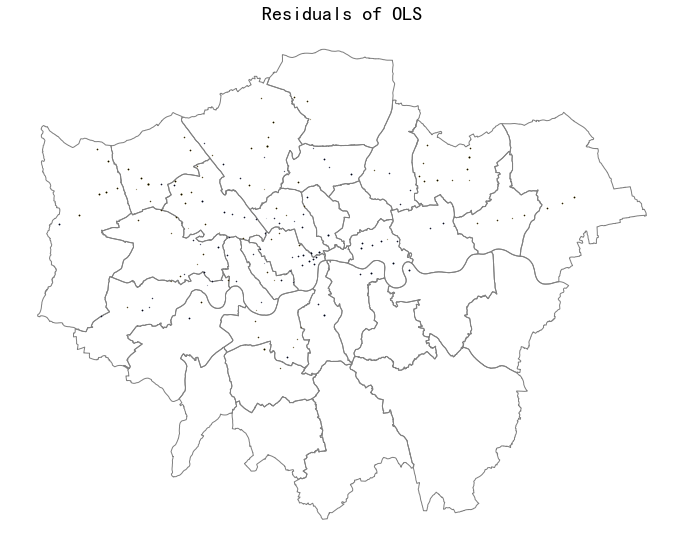

In [557]:
base = London.plot(figsize=(12,12),facecolor='none',edgecolor='grey')

for i in inout_df.index:    
    if inout_df.loc[i,'ols_res'] > 0:        
        plt.scatter(inout_df.loc[i,'coord_x'],inout_df.loc[i,'coord_y'],marker='o',color='royalblue',alpha=0.6,s=abs(inout_df.loc[i,'ols_res'])/2)
        plt.scatter(inout_df.loc[i,'coord_x'],inout_df.loc[i,'coord_y'],marker='o',color='red',edgecolor='black',s=abs(inout_df.loc[i,'ols_res'])/2)    
    else:        
        plt.scatter(inout_df.loc[i,'coord_x'],inout_df.loc[i,'coord_y'],marker='o',color='gold',alpha=0.6,s=abs(inout_df.loc[i,'ols_res'])/2)        
        plt.scatter(inout_df.loc[i,'coord_x'],inout_df.loc[i,'coord_y'],marker='o',color='red',edgecolor='black',s=abs(inout_df.loc[i,'ols_res'])/2)
plt.title('Residuals of OLS',fontsize=20)
plt.axis('off')
plt.show()

### 考虑空间效应的OLS分析

In [ ]:
考虑空间效应的OLS分析，通过建立空间权重，然后会默认计算空间滞后、空间误差、空间自回归移动平均的拉格朗日乘子统计量，这个统计量的结果是是否使用SEM或者SLM的最关键的充分条件。最终依据拉格朗日乘子统计量得出用哪种空间计量模型。

我想知道怎么建立空间权重，怎么计算空间滞后、空间误差、空间自回归移动平均的拉格朗日乘子统计量

In [441]:
inout_df.columns

Index(['station', 'relative_outflow(work)', 'coord_x', 'coord_y',
       'relative_inflow(work)', 'white_total(orig)', 'asian_total(orig)',
       'black_total(orig)', 'teenager_age(orig)', 'young_age(orig)',
       'middle_age(orig)', 'old_age(orig)', 'house_pri(orig)', 'geometry'],
      dtype='object')

In [627]:
# 假设你有一个变量 y 和一个自变量 x
y = np.array(inout_df['relative_inflow(work)'])
x = np.array(inout_df[['white_total(orig)',
       'black_total(orig)', 'teenager_age(orig)', 'young_age(orig)',
       'middle_age(orig)', 'old_age(orig)', 'house_pri(orig)']])

In [451]:
wq

In [445]:
import numpy as np
import pysal
from pysal.model.spreg import OLS, GM_Lag

# 假设你有一个变量 y 和一个自变量 x

# 建立空间权重矩阵
#w = pysal.weights.Queen.from_dataframe(df)

# 普通OLS回归
#model_ols = OLS(y, x)

# 空间滞后模型
model_lag = GM_Lag(y, x, wq)

# 计算拉格朗日乘子统计量
lm_error = model_lag.lm_error
lm_sarma = model_lag.lm_sarma

Exception: all input data must be either numpy arrays or sparse csr matrices

### Spatial Lag Model

In [493]:
columns_x = ['white_total(orig)',
 'black_total(orig)',
 'teenager_age(orig)',
 'young_age(orig)',
 'middle_age(orig)',
 'old_age(orig)',
 'house_pri(orig)']

In [559]:
splag = spreg.ML_Lag(y,x,wq,name_y='log_inflow',name_x=list(columns_x),name_ds='DIDI_chengdu',name_w='queen')
print(splag.summary)

lr = spreg.diagnostics.likratiotest(ols,splag)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :DIDI_chengdu
Weights matrix      :       queen
Dependent Variable  :  log_inflow                Number of Observations:         158
Mean dependent var  :      2.0701                Number of Variables   :           9
S.D. dependent var  :      0.8413                Degrees of Freedom    :         149
Pseudo R-squared    :      0.5599
Spatial Pseudo R-squared:  0.3654
Sigma-square ML     :       0.314                Log likelihood        :    -140.162
S.E of regression   :       0.560                Akaike info criterion :     298.323
                                                 Schwarz criterion     :     325.887

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

In [649]:
# 获取估计的空间滞后参数 Rho (ρ)
rho_estimated = splag.rho
rho_estimated

0.6406923680057403

In [652]:
# 进行似然比检验
lr_test_result = spreg.diagnostics.likratiotest(ols, splag)
lr_test_result

{'likr': 59.1470050951566, 'df': 1, 'p-value': 1.4632188051929376e-14}

### Spatial Error Model

In [646]:
splag = spreg.BaseGM_Error(y,x,w)
print(splag.summary)

lr = spreg.diagnostics.likratiotest(ols,splag)

IndexError: invalid index to scalar variable.

In [641]:
spreg.BaseGM_Error?

### Spatial Regression Model

In [207]:
inout_df.columns

Index(['station', 'relative_outflow(work)', 'relative_inflow(work)',
       'white_total(orig)', 'asian_total(orig)', 'black_total(orig)',
       'teenager_age(orig)', 'young_age(orig)', 'middle_age(orig)',
       'old_age(orig)', 'house_pri(orig)', 'coord_x', 'coord_y'],
      dtype='object')

In [208]:
column_to_drop = ['station','coord_x','coord_y']
inout_df2 = inout_df.drop(column_to_drop,axis=1)

In [227]:
from sklearn.model_selection import train_test_split
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(inout_df2[inout_df2.columns[inout_df2.columns != 'relative_inflow(work)']],
                                                    inout_df2['relative_outflow(work)'],
                                                    test_size=0.3,
                                                    random_state=1)

In [671]:
inout_df.columns

Index(['station', 'relative_outflow(work)', 'coord_x', 'coord_y',
       'relative_inflow(work)', 'white_total(orig)', 'asian_total(orig)',
       'black_total(orig)', 'teenager_age(orig)', 'young_age(orig)',
       'middle_age(orig)', 'old_age(orig)', 'house_pri(orig)', 'geometry',
       'log_inflow', 'ols_res'],
      dtype='object')

In [229]:
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from math import sqrt

# Initiate linear regression model
lr = LinearRegression()

# Fit the model
lr.fit(X_train, y_train)

### Train set
# Model prediction on training set
y_pred_lr_train = lr.predict(X_train)

# Calculate the R2, MAE and MSE of the model
lr_mae_train = metrics.mean_absolute_error(y_train, y_pred_lr_train)
lr_mse_train = metrics.mean_squared_error(y_train, y_pred_lr_train)
lr_rmse_train = sqrt(metrics.mean_squared_error(y_train, y_pred_lr_train))

# Printing the metrics (Train set)
lr_R2_train = metrics.r2_score(y_train, y_pred_lr_train)
print('Training Set: ')
print('Linear Regression Accuracy:', lr.score(X_train, y_train))
print('R2 square(Linear Regression):',lr_R2_train)
print('MAE(Linear Regression): ', lr_mae_train)
print('MSE(Linear Regression): ', lr_mse_train)
print('RMSE(Linear Regression): ', lr_rmse_train)
print('\n')

### Test set
# Model prediction on test set
y_pred_lr_test = lr.predict(X_test)

# Calculate the R2, MAE and MSE of the model
lr_mae_test = metrics.mean_absolute_error(y_test, y_pred_lr_test)
lr_mse_test = metrics.mean_squared_error(y_test, y_pred_lr_test)
lr_rmse_test = sqrt(metrics.mean_squared_error(y_test, y_pred_lr_test))

# Printing the metrics (Test set)
lr_R2_test = metrics.r2_score(y_test, y_pred_lr_test)
print('Testing Set: ')
print('Linear Regression Accuracy:', lr.score(X_test, y_test))
print('R2 square(Linear Regression):',lr_R2_test)
print('MAE(Linear Regression): ', lr_mae_test)
print('MSE(Linear Regression): ', lr_mse_test)
print('RMSE(Linear Regression): ', lr_rmse_test)

Training Set: 
Linear Regression Accuracy: 1.0
R2 square(Linear Regression): 1.0
MAE(Linear Regression):  1.1859829685386203e-16
MSE(Linear Regression):  2.714457863151673e-32
RMSE(Linear Regression):  1.6475611864667342e-16


Testing Set: 
Linear Regression Accuracy: 1.0
R2 square(Linear Regression): 1.0
MAE(Linear Regression):  1.3819963691948564e-16
MSE(Linear Regression):  3.6769212521592976e-32
RMSE(Linear Regression):  1.9175299872907587e-16


In [230]:
# Import Library
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

# Initialize the model
lasso = Lasso()

# Hyper parameters setting
hyperParameters = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]}

# Hyper parameters tunning
lasso_regressor = GridSearchCV(lasso, hyperParameters, scoring='neg_mean_squared_error', cv=5)

# Training
lasso_regressor.fit(X_train,y_train)

# Print out the best parameters of Lasso
print("Best value for lambda : ",lasso_regressor.best_params_,'\n')

### Train set
# Model prediction on training set
y_pred_lasso_train = lasso_regressor.predict(X_train)

# Calculate the R2, MAE and MSE of the model
lasso_mae_train = metrics.mean_absolute_error(y_train, y_pred_lasso_train)
lasso_mse_train = metrics.mean_squared_error(y_train, y_pred_lasso_train)
lasso_rmse_train = sqrt(metrics.mean_squared_error(y_train, y_pred_lasso_train))

# Printing the metrics (Train set)
lasso_R2_train = metrics.r2_score(y_train, y_pred_lasso_train)
print('Training Set: ')
print('Lasso Regression Accuracy:', lasso_regressor.score(X_train, y_train))
print('R2 square(Lasso Regression):',lasso_R2_train)
print('MAE(Lasso Regression): ', lasso_mae_train)
print('MSE(Lasso Regression): ', lasso_mse_train)
print('RMSE(Lasso Regression): ', lasso_rmse_train)
print('\n')


### Test set
# Model prediction on test set
y_pred_lasso_test = lasso_regressor.predict(X_test)

# Calculate the R2, MAE and MSE of the model
lasso_mae_test = metrics.mean_absolute_error(y_test, y_pred_lasso_test)
lasso_mse_test = metrics.mean_squared_error(y_test, y_pred_lasso_test)
lasso_rmse_test = sqrt(metrics.mean_squared_error(y_test, y_pred_lasso_test))

# Printing the metrics (Test set)
lasso_R2_test = metrics.r2_score(y_test, y_pred_lasso_test)
print('Testing Set: ')
print('Lasso Regression Accuracy:', lasso_regressor.score(X_test, y_test))
print('R2 square(Lasso Regression):',lasso_R2_test)
print('MAE(Lasso Regression): ', lasso_mae_test)
print('MSE(Lasso Regression): ', lasso_mse_test)
print('RMSE(Lasso Regression): ', lasso_rmse_test)

Best value for lambda :  {'alpha': 1e-15} 

Training Set: 
Lasso Regression Accuracy: -4.1687448731887105e-29
R2 square(Lasso Regression): 1.0
MAE(Lasso Regression):  4.632279408541122e-15
MSE(Lasso Regression):  4.1687448731887105e-29
RMSE(Lasso Regression):  6.45658181485274e-15


Testing Set: 
Lasso Regression Accuracy: -5.040267800491578e-29
R2 square(Lasso Regression): 1.0
MAE(Lasso Regression):  5.543019746904558e-15
MSE(Lasso Regression):  5.040267800491578e-29
RMSE(Lasso Regression):  7.099484347818212e-15


In [231]:
# Import Library
from sklearn.tree import DecisionTreeRegressor

# Initialize the model 
dt = DecisionTreeRegressor(random_state = 0)

# Fit the model
dt.fit(X_train, y_train)

# Model prediction on test set
y_pred_dt = dt.predict(X_test)

### Train set
# Model prediction on training set
y_pred_dt_train = dt.predict(X_train)

# Calculate the R2, MAE and MSE of the model
dt_mae_train = metrics.mean_absolute_error(y_train, y_pred_dt_train)
dt_mse_train = metrics.mean_squared_error(y_train, y_pred_dt_train)
dt_rmse_train = sqrt(metrics.mean_squared_error(y_train, y_pred_dt_train))

# Printing the metrics (Train set)
dt_R2_train = metrics.r2_score(y_train, y_pred_dt_train)
print('Training Set: ')
print('Decision Tree Accuracy:', dt.score(X_train, y_train))
print('R2 square(Decision Tree):',dt_R2_train)
print('MAE(Decision Tree): ', dt_mae_train)
print('MSE(Decision Tree): ', dt_mse_train)
print('RMSE(Decision Tree): ', dt_rmse_train)
print('\n')


### Test set
# Model prediction on test set
y_pred_dt_test = dt.predict(X_test)

# Calculate the R2, MAE and MSE of the model
dt_mae_test = metrics.mean_absolute_error(y_test, y_pred_dt_test)
dt_mse_test = metrics.mean_squared_error(y_test, y_pred_dt_test)
dt_rmse_test = sqrt(metrics.mean_squared_error(y_test, y_pred_dt_test))

# Printing the metrics (Test set)
dt_R2_test = metrics.r2_score(y_test, y_pred_dt_test)
print('Testing Set: ')
print('Decision Tree Accuracy:', dt.score(X_test, y_test))
print('R2 square(Decision Tree):',dt_R2_test)
print('MAE(Decision Tree): ', dt_mae_test)
print('MSE(Decision Tree): ', dt_mse_test)
print('RMSE(Decision Tree): ', dt_rmse_test)

Training Set: 
Decision Tree Accuracy: 1.0
R2 square(Decision Tree): 1.0
MAE(Decision Tree):  0.0
MSE(Decision Tree):  0.0
RMSE(Decision Tree):  0.0


Testing Set: 
Decision Tree Accuracy: 0.9922761176967774
R2 square(Decision Tree): 0.9922761176967774
MAE(Decision Tree):  0.008482713634025925
MSE(Decision Tree):  0.00021468347827126546
RMSE(Decision Tree):  0.01465208102186394


### OLS Result Plot

#### Residual vs. Fitted plot

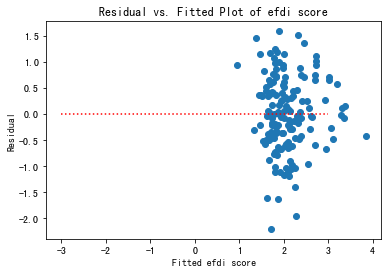

In [662]:
# plot 
plt.scatter(model.fittedvalues, model.resid)
# adding title and labels
plt.plot([-3,3],[0,0], c='r', linestyle=':')
plt.xlabel('Fitted efdi score')
plt.ylabel('Residual')

plt.title('Residual vs. Fitted Plot of efdi score')
plt.savefig('residual.png')
plt.show()

#### Fitted Value Distribution

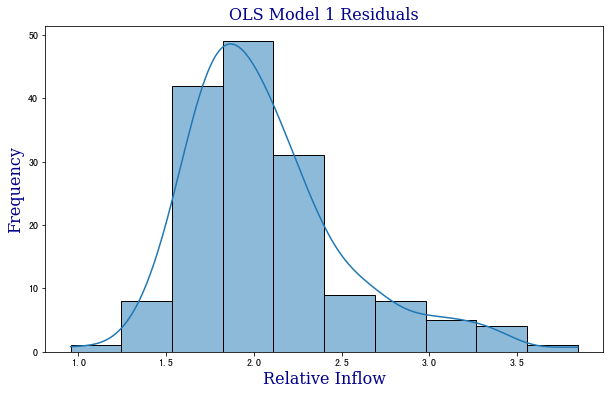

In [668]:
import seaborn as sns
import matplotlib.pyplot as plt

# 绘制直方图和分布趋势走向线
plt.figure(figsize=(10, 6))
sns.histplot(data=model.fittedvalues, bins=10, kde=True)

# 设置标题和标签的字体大小
font = {'family': 'serif', 'color':  'darkblue', 'weight': 'normal', 'size': 16}
plt.title('OLS Model 1 Residuals', fontdict=font)
plt.xlabel('Relative Inflow', fontdict=font)
plt.ylabel('Frequency', fontdict=font)

plt.savefig('./figure/relative_inflow_distribution.pdf')
# 显示图形
plt.show()


In [ ]:
# display model summary
#print(multi_model.summary())
  
# modify figure size
fig = plt.figure(figsize=(14, 8))
  
# creating regression plots
fig = sm.graphics.plot_regress_exog(model, 'log_inflow', fig=fig)

In [663]:
# base code
import numpy as np
import seaborn as sns
from statsmodels.tools.tools import maybe_unwrap_results
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from typing import Type

import statsmodels

style_talk = 'seaborn-talk'    #refer to plt.style.available

class Linear_Reg_Diagnostic():
    """
    Diagnostic plots to identify potential problems in a linear regression fit.
    Mainly,
        a. non-linearity of data
        b. Correlation of error terms
        c. non-constant variance
        d. outliers
        e. high-leverage points
        f. collinearity

    Author:
        Prajwal Kafle (p33ajkafle@gmail.com, where 3 = r)
        Does not come with any sort of warranty.
        Please test the code one your end before using.
    """

    def __init__(self,
                 results: Type[statsmodels.regression.linear_model.RegressionResultsWrapper]) -> None:
        """
        For a linear regression model, generates following diagnostic plots:

        a. residual
        b. qq
        c. scale location and
        d. leverage

        and a table

        e. vif

        Args:
            results (Type[statsmodels.regression.linear_model.RegressionResultsWrapper]):
                must be instance of statsmodels.regression.linear_model object

        Raises:
            TypeError: if instance does not belong to above object

        Example:
        >>> import numpy as np
        >>> import pandas as pd
        >>> import statsmodels.formula.api as smf
        >>> x = np.linspace(-np.pi, np.pi, 100)
        >>> y = 3*x + 8 + np.random.normal(0,1, 100)
        >>> df = pd.DataFrame({'x':x, 'y':y})
        >>> res = smf.ols(formula= "y ~ x", data=df).fit()
        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls(plot_context="seaborn-paper")

        In case you do not need all plots you can also independently make an individual plot/table
        in following ways

        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls.residual_plot()
        >>> cls.qq_plot()
        >>> cls.scale_location_plot()
        >>> cls.leverage_plot()
        >>> cls.vif_table()
        """

        if isinstance(results, statsmodels.regression.linear_model.RegressionResultsWrapper) is False:
            raise TypeError("result must be instance of statsmodels.regression.linear_model.RegressionResultsWrapper object")

        self.results = maybe_unwrap_results(results)

        self.y_true = self.results.model.endog
        self.y_predict = self.results.fittedvalues
        self.xvar = self.results.model.exog
        self.xvar_names = self.results.model.exog_names

        self.residual = np.array(self.results.resid)
        influence = self.results.get_influence()
        self.residual_norm = influence.resid_studentized_internal
        self.leverage = influence.hat_matrix_diag
        self.cooks_distance = influence.cooks_distance[0]
        self.nparams = len(self.results.params)

    def __call__(self, plot_context='seaborn-paper'):
        # print(plt.style.available)
        with plt.style.context(plot_context):
            fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
            self.residual_plot(ax=ax[0,0])
            self.qq_plot(ax=ax[0,1])
            self.scale_location_plot(ax=ax[1,0])
            self.leverage_plot(ax=ax[1,1])
            plt.show()

        self.vif_table()
        return fig, ax


    def residual_plot(self, ax=None):
        """
        Residual vs Fitted Plot

        Graphical tool to identify non-linearity.
        (Roughly) Horizontal red line is an indicator that the residual has a linear pattern
        """
        if ax is None:
            fig, ax = plt.subplots()

        sns.residplot(
            x=self.y_predict,
            y=self.residual,
            lowess=True,
            scatter_kws={'alpha': 0.5},
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        residual_abs = np.abs(self.residual)
        abs_resid = np.flip(np.sort(residual_abs))
        abs_resid_top_3 = abs_resid[:3]
        for i, _ in enumerate(abs_resid_top_3):
            ax.annotate(
                i,
                xy=(self.y_predict[i], self.residual[i]),
                color='C3')

        ax.set_title('Residuals vs Fitted', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel('Residuals')
        return ax

    def qq_plot(self, ax=None):
        """
        Standarized Residual vs Theoretical Quantile plot

        Used to visually check if residuals are normally distributed.
        Points spread along the diagonal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        QQ = ProbPlot(self.residual_norm)
        QQ.qqplot(line='45', alpha=0.5, lw=1, ax=ax)

        # annotations
        abs_norm_resid = np.flip(np.argsort(np.abs(self.residual_norm)), 0)
        abs_norm_resid_top_3 = abs_norm_resid[:3]
        for r, i in enumerate(abs_norm_resid_top_3):
            ax.annotate(
                i,
                xy=(np.flip(QQ.theoretical_quantiles, 0)[r], self.residual_norm[i]),
                ha='right', color='C3')

        ax.set_title('Normal Q-Q', fontweight="bold")
        ax.set_xlabel('Theoretical Quantiles')
        ax.set_ylabel('Standardized Residuals')
        return ax

    def scale_location_plot(self, ax=None):
        """
        Sqrt(Standarized Residual) vs Fitted values plot

        Used to check homoscedasticity of the residuals.
        Horizontal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        residual_norm_abs_sqrt = np.sqrt(np.abs(self.residual_norm))

        ax.scatter(self.y_predict, residual_norm_abs_sqrt, alpha=0.5);
        sns.regplot(
            x=self.y_predict,
            y=residual_norm_abs_sqrt,
            scatter=False, ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        abs_sq_norm_resid = np.flip(np.argsort(residual_norm_abs_sqrt), 0)
        abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
        for i in abs_sq_norm_resid_top_3:
            ax.annotate(
                i,
                xy=(self.y_predict[i], residual_norm_abs_sqrt[i]),
                color='C3')
        ax.set_title('Scale-Location', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel(r'$\sqrt{|\mathrm{Standardized\ Residuals}|}$');
        return ax

    def leverage_plot(self, ax=None):
        """
        Residual vs Leverage plot

        Points falling outside Cook's distance curves are considered observation that can sway the fit
        aka are influential.
        Good to have none outside the curves.
        """
        if ax is None:
            fig, ax = plt.subplots()

        ax.scatter(
            self.leverage,
            self.residual_norm,
            alpha=0.5);

        sns.regplot(
            x=self.leverage,
            y=self.residual_norm,
            scatter=False,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        leverage_top_3 = np.flip(np.argsort(self.cooks_distance), 0)[:3]
        for i in leverage_top_3:
            ax.annotate(
                i,
                xy=(self.leverage[i], self.residual_norm[i]),
                color = 'C3')

        xtemp, ytemp = self.__cooks_dist_line(0.5) # 0.5 line
        ax.plot(xtemp, ytemp, label="Cook's distance", lw=1, ls='--', color='red')
        xtemp, ytemp = self.__cooks_dist_line(1) # 1 line
        ax.plot(xtemp, ytemp, lw=1, ls='--', color='red')

        ax.set_xlim(0, max(self.leverage)+0.01)
        ax.set_title('Residuals vs Leverage', fontweight="bold")
        ax.set_xlabel('Leverage')
        ax.set_ylabel('Standardized Residuals')
        ax.legend(loc='upper right')
        return ax

    def vif_table(self):
        """
        VIF table

        VIF, the variance inflation factor, is a measure of multicollinearity.
        VIF > 5 for a variable indicates that it is highly collinear with the
        other input variables.
        """
        vif_df = pd.DataFrame()
        vif_df["Features"] = self.xvar_names
        vif_df["VIF Factor"] = [variance_inflation_factor(self.xvar, i) for i in range(self.xvar.shape[1])]

        print(vif_df
                .sort_values("VIF Factor")
                .round(2))


    def __cooks_dist_line(self, factor):
        """
        Helper function for plotting Cook's distance curves
        """
        p = self.nparams
        formula = lambda x: np.sqrt((factor * p * (1 - x)) / x)
        x = np.linspace(0.001, max(self.leverage), 50)
        y = formula(x)
        return x, y

In [664]:
cls = Linear_Reg_Diagnostic(model)

<AxesSubplot:title={'center':'Normal Q-Q'}, xlabel='Theoretical Quantiles', ylabel='Standardized Residuals'>

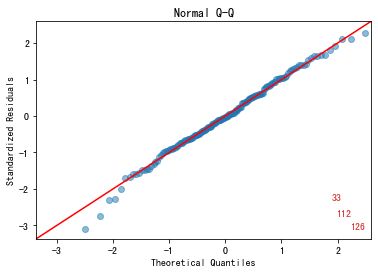

In [665]:
cls.qq_plot()

## Model Performance